# 0.0. IMPORTS

In [7]:
import pandas              as pd
import inflection
import math
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec

import datetime              
from tabulate              import tabulate
from scipy.stats           import chi2_contingency
from IPython.display       import Image
from IPython.core.display  import HTML

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor
import xgboost             as xgb

from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM

import random
import warnings
warnings.filterwarnings( 'ignore' )

## 0.1 Helper Function

In [8]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( (y - yhat ) / y ) )

def cross_validation( X_training, kfold, model_name, model, verbose=False ):
    
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation
        validation_start_date = X_training['date'].max() - datetime.timedelta( days=k*30*3 )
        validation_end_date = X_training['date'].max() - datetime.timedelta( days=(k-1)*30*3 )

        # filtering dataset
        training = X_training[X_training['date'] < validation_start_date]
        validation = X_training[(X_training['date'] >= validation_start_date) & (X_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales' ], axis=1 )
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold interation
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( { 'Model Name': model_name,
                            'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                            'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                            'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

In [9]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [10]:
df_raw = pd.read_csv('data/train.csv', low_memory=False)

In [11]:
df_raw.sample()

,date,store,item,sales
450132,2015-07-26,7,25,93


# 1.0 STEP 01 - DESCRIPTION OF DATA

In [12]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [7]:
df1.columns

# It's not necessary to change the name or the format of the column names.

Index(['date', 'store', 'item', 'sales'], dtype='object')

## 1.2 Data Dimensions

In [8]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )
# Evaluate the possibilite do use this project in your computer

Number of Rows: 913000
Number of Cols: 4


## 1.3 Data Types

In [9]:
df1.dtypes
# Observe date. It has a different data type.

date     object
store     int64
item      int64
sales     int64
dtype: object

In [10]:
# I will use "to_date" to change to datetime.
df1['date'] = pd.to_datetime( df1['date'] )

In [11]:
df1.dtypes
# We can see that everything is ok!

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

## 1.4 Check NA

In [12]:
df1.isna().sum()
# No missing values.

date     0
store    0
item     0
sales    0
dtype: int64

## 1.7. Descriptive Statistical

In [13]:
# As we not have categorical variables, I will just separate numeric values from the datetime value.
num_attributes = df1.select_dtypes( include=['int64'] )

In [14]:
num_attributes.sample()

,store,item,sales
45513,5,3,48


### 1.7.1 Numerical Attributes

In [15]:

# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ( ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

In [16]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,10.0,9.0,5.500000,5.5,2.872281,0.000000,-1.224243
1,item,1.0,50.0,49.0,25.500000,25.5,14.430870,0.000000,-1.200960
2,sales,0.0,231.0,231.0,52.250287,47.0,28.801128,0.867112,0.509070


<AxesSubplot: xlabel='sales', ylabel='Density'>

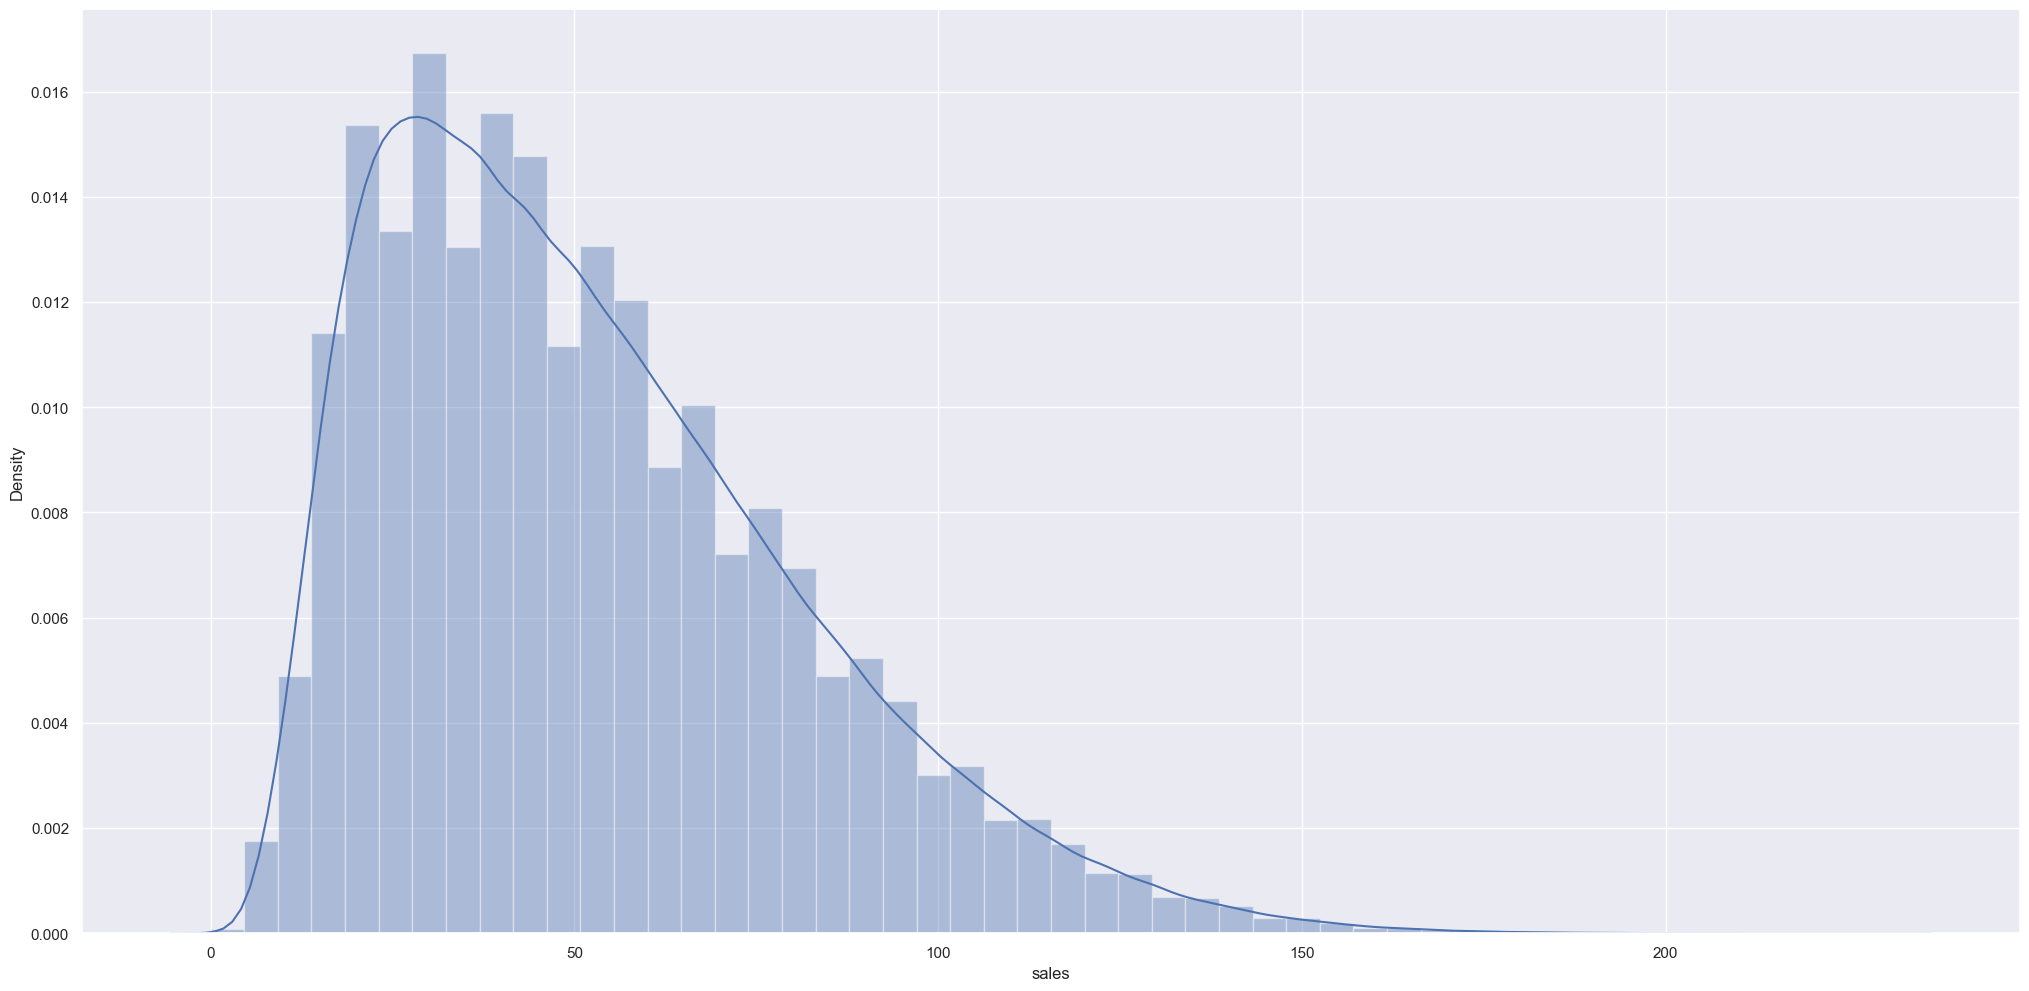

In [17]:
sns.distplot( df1['sales'] )

# 2.0 STEP 02 - FEATURE ENGINEERING

In [18]:
df2 = df1.copy()

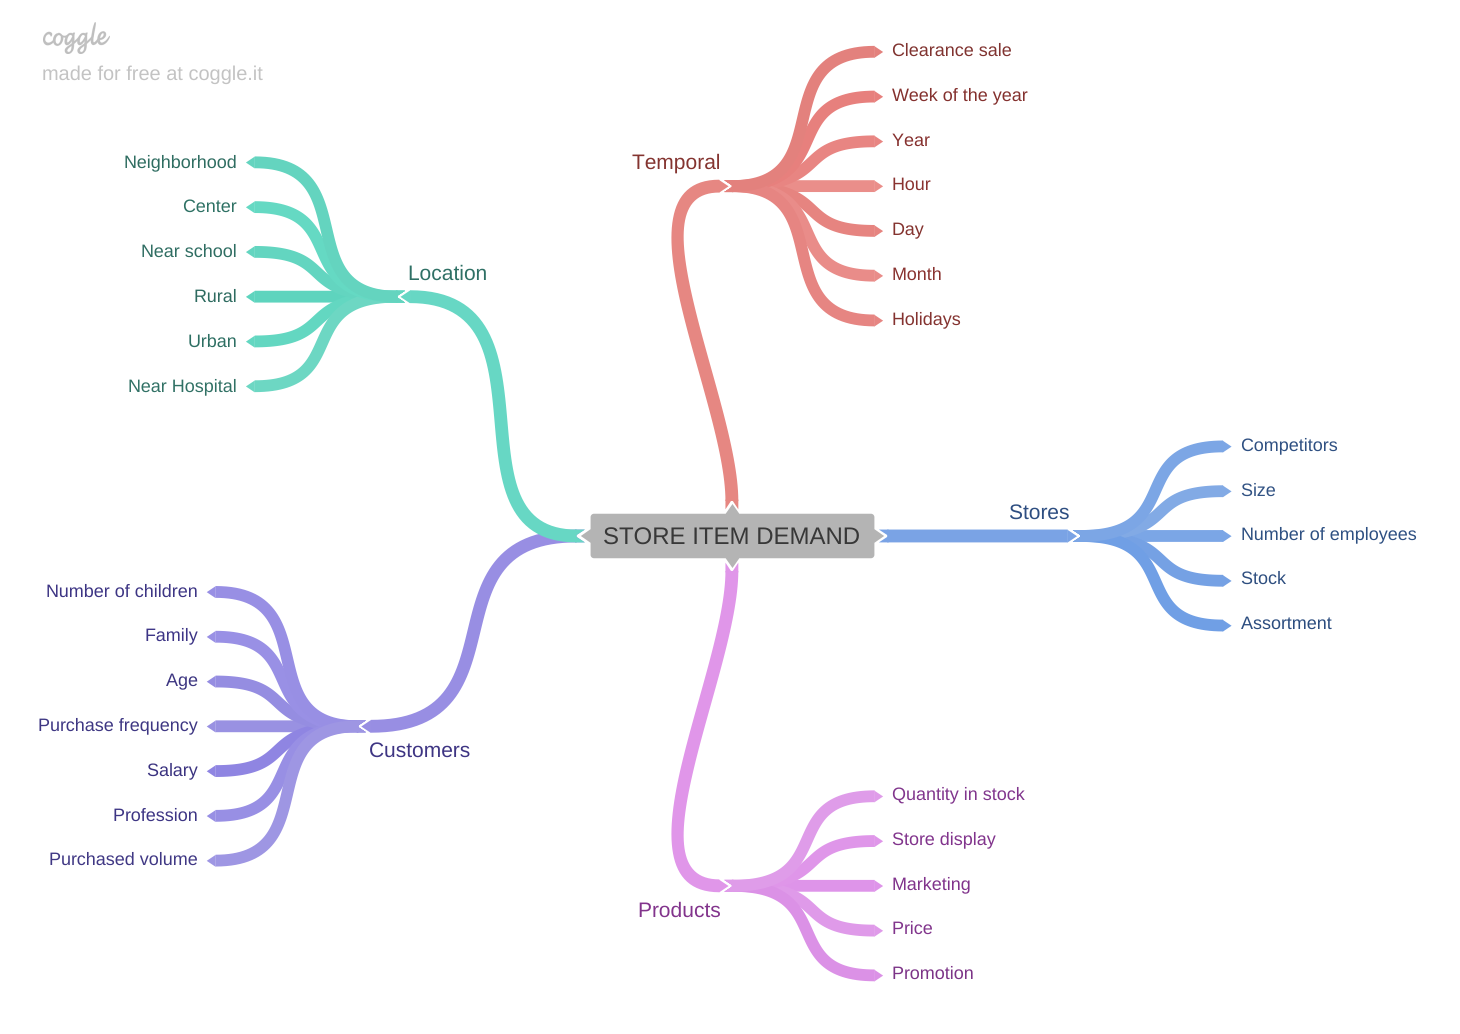

In [19]:
Image( "image/Hyphoteses_Map.png")

## 2.1 Creation of Hyphoteses

### 2.1.1. Shop Hypotheses

**1.** Stores with more employees should sell more items.

**2.** Stores with greater inventory capacity should sell more items.

**3.** Larger stores should sell more items.

**4.** Stores with closer competitors should sell less items.

**5.** Stores with longer competitors should sell more items.

### 2.1.2. Product Hypotheses

**1.** Stores that invest more in Marketing should sell more items.

**2.** Stores with greater product exposure should sell more items.

**3.** Stores with lower prices should sell more items.

**4.** Stores with more aggressive promotions (bigger discounts), should sell more items.

**5.** Stores with active promotions for longer should sell more items.

**6.** Stores with more promotion days should venerate more items.

**7.** Stores with more consecutive promotions should sell more items.

### 2.1.3 Time Hyphoteses

**1.** Stores open during the Christmas holiday should sell more items.

**2.** Stores should be selling more items over the years.

**3.** Stores should sell more items in the second half of the year.

**4.** Stores should sell more items after the 10th of each month.

**5.** Stores should sell less items on weekends.

**6.** Stores should sell less items during school holidays.

## 2.2 Final List of Hyphoteses

In [20]:
# As we only have information on sales dates in this dataset, I will use only the time hypothesis items in the final hypothesis list.

**1.** Stores should be selling more items over the years.

**2.** Stores should sell more items in the second half of the year.

**3.** Stores should sell more items after the 10th of each month.

**4.** Stores should sell less items on weekends.

## 2.3 Feature Engineering

In [21]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# day of week
df2['day_of_week'] = df2['date'].dt.dayofweek

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

In [22]:
df2.sample(5).T

,711923,260772,571303,622419,785218
date,2017-05-29 00:00:00,2017-01-20 00:00:00,2017-05-11 00:00:00,2017-04-29 00:00:00,2013-02-08 00:00:00
store,10,3,3,1,1
item,39,15,32,35,44
sales,51,78,64,100,16
year,2017,2017,2017,2017,2013
month,5,1,5,4,2
day,29,20,11,29,8
day_of_week,0,4,3,5,4
week_of_year,22,3,19,17,6
year_week,2017-22,2017-03,2017-19,2017-17,2013-05


# 3.0 STEP 03 - VARIABLE FILTERING

In [23]:
df3 = df2.copy()

In [24]:
df3.head()

,date,store,item,sales,year,month,day,day_of_week,week_of_year,year_week
0,2013-01-01,1,1,13,2013,1,1,1,1,2013-00
1,2013-01-02,1,1,11,2013,1,2,2,1,2013-00
2,2013-01-03,1,1,14,2013,1,3,3,1,2013-00
3,2013-01-04,1,1,13,2013,1,4,4,1,2013-00
4,2013-01-05,1,1,10,2013,1,5,5,1,2013-00


## 3.1 Line Filtering

In [25]:
df3 = df3[df3['sales'] > 0]

## 3.2 Column Filtering

In [26]:
# There isn't any columns desnecessary in this dataset.

# 4.0 STEP 04 - EXPLORATORY DATA ANALYSIS

In [27]:
df4 = df3.copy()

## 4.1 Univariable Analysis

### 4.1.1 Response Variable

<AxesSubplot: xlabel='sales'>

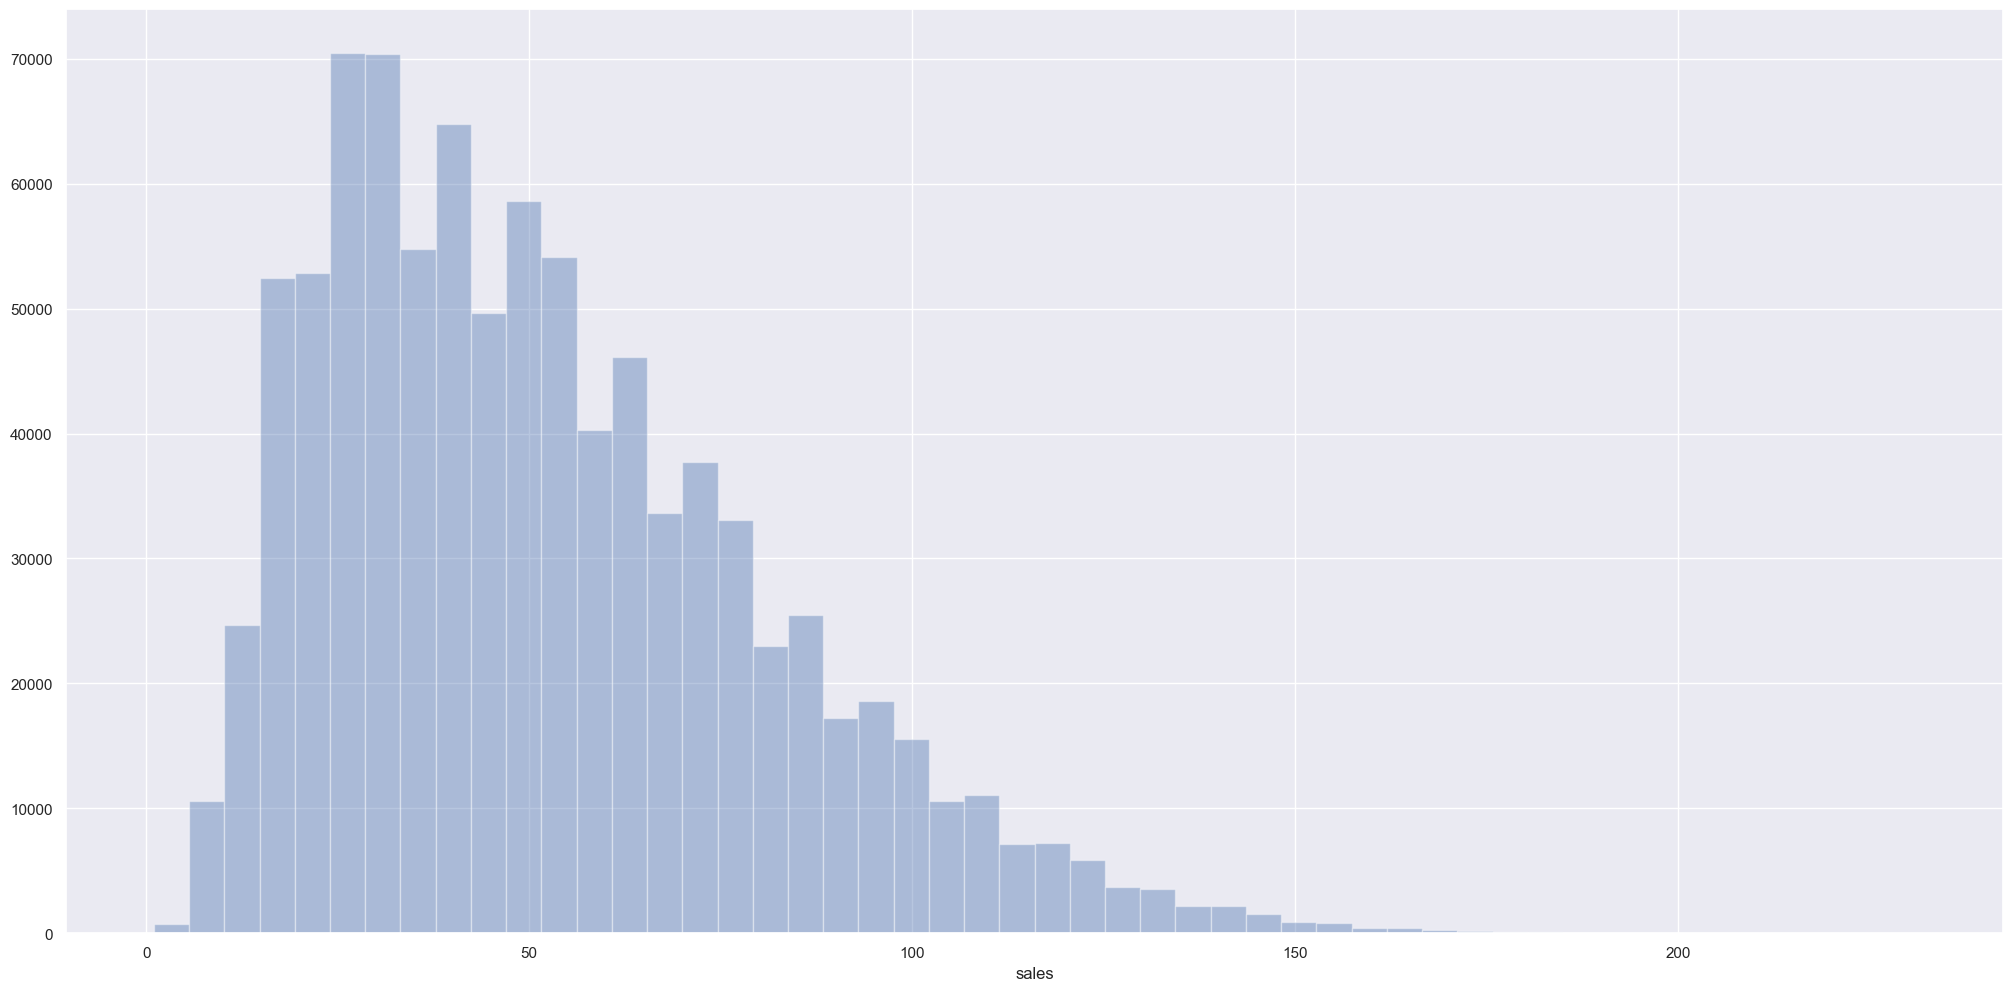

In [28]:
sns.distplot( df4['sales'], kde=False )

### 4.1.2. Numerical Variable

array([[<AxesSubplot: title={'center': 'store'}>,
        <AxesSubplot: title={'center': 'item'}>],
       [<AxesSubplot: title={'center': 'sales'}>, <AxesSubplot: >]],
      dtype=object)

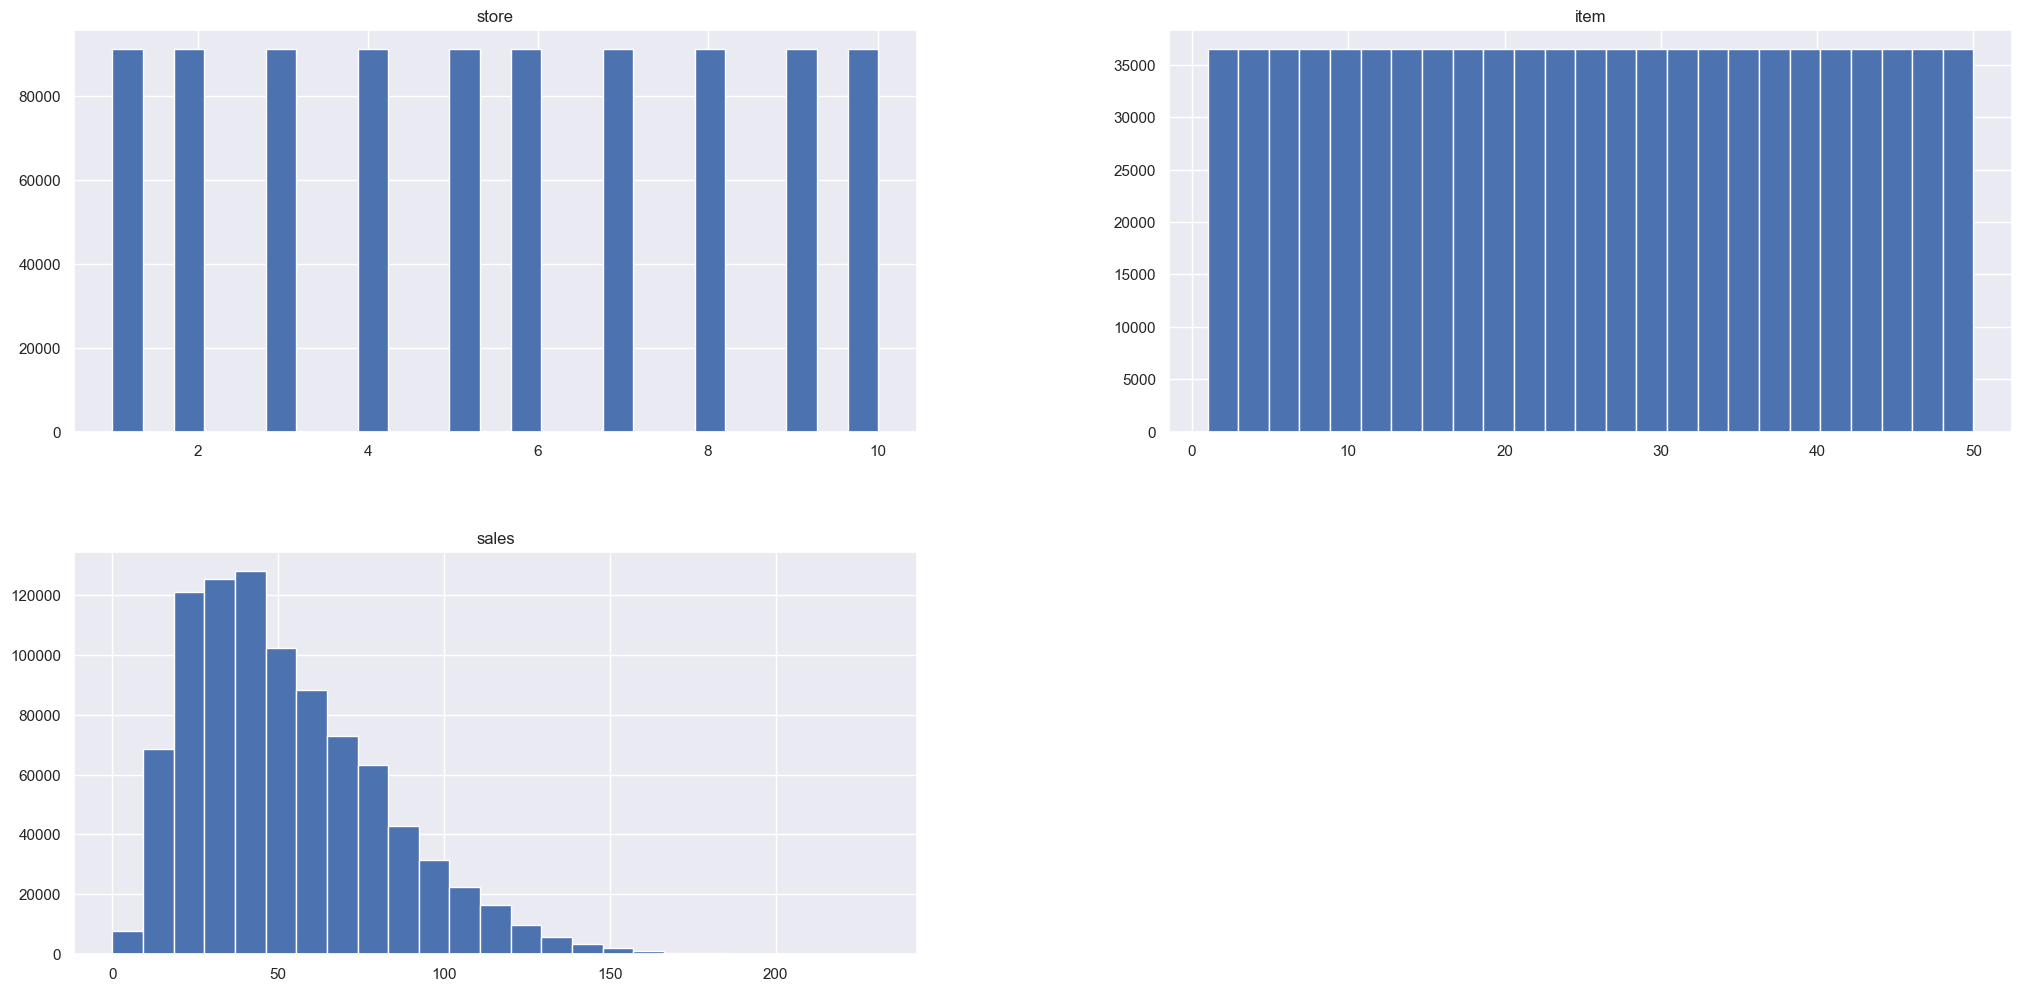

In [29]:
num_attributes.hist( bins=25 )

### 4.1.3. Categorical Variable

In [30]:
# There isn't categorical variable.

## 4.2. Bivariate Analysis

### H1. Stores should be selling more items over the years.
**TRUE** Stores selling more items over the years.

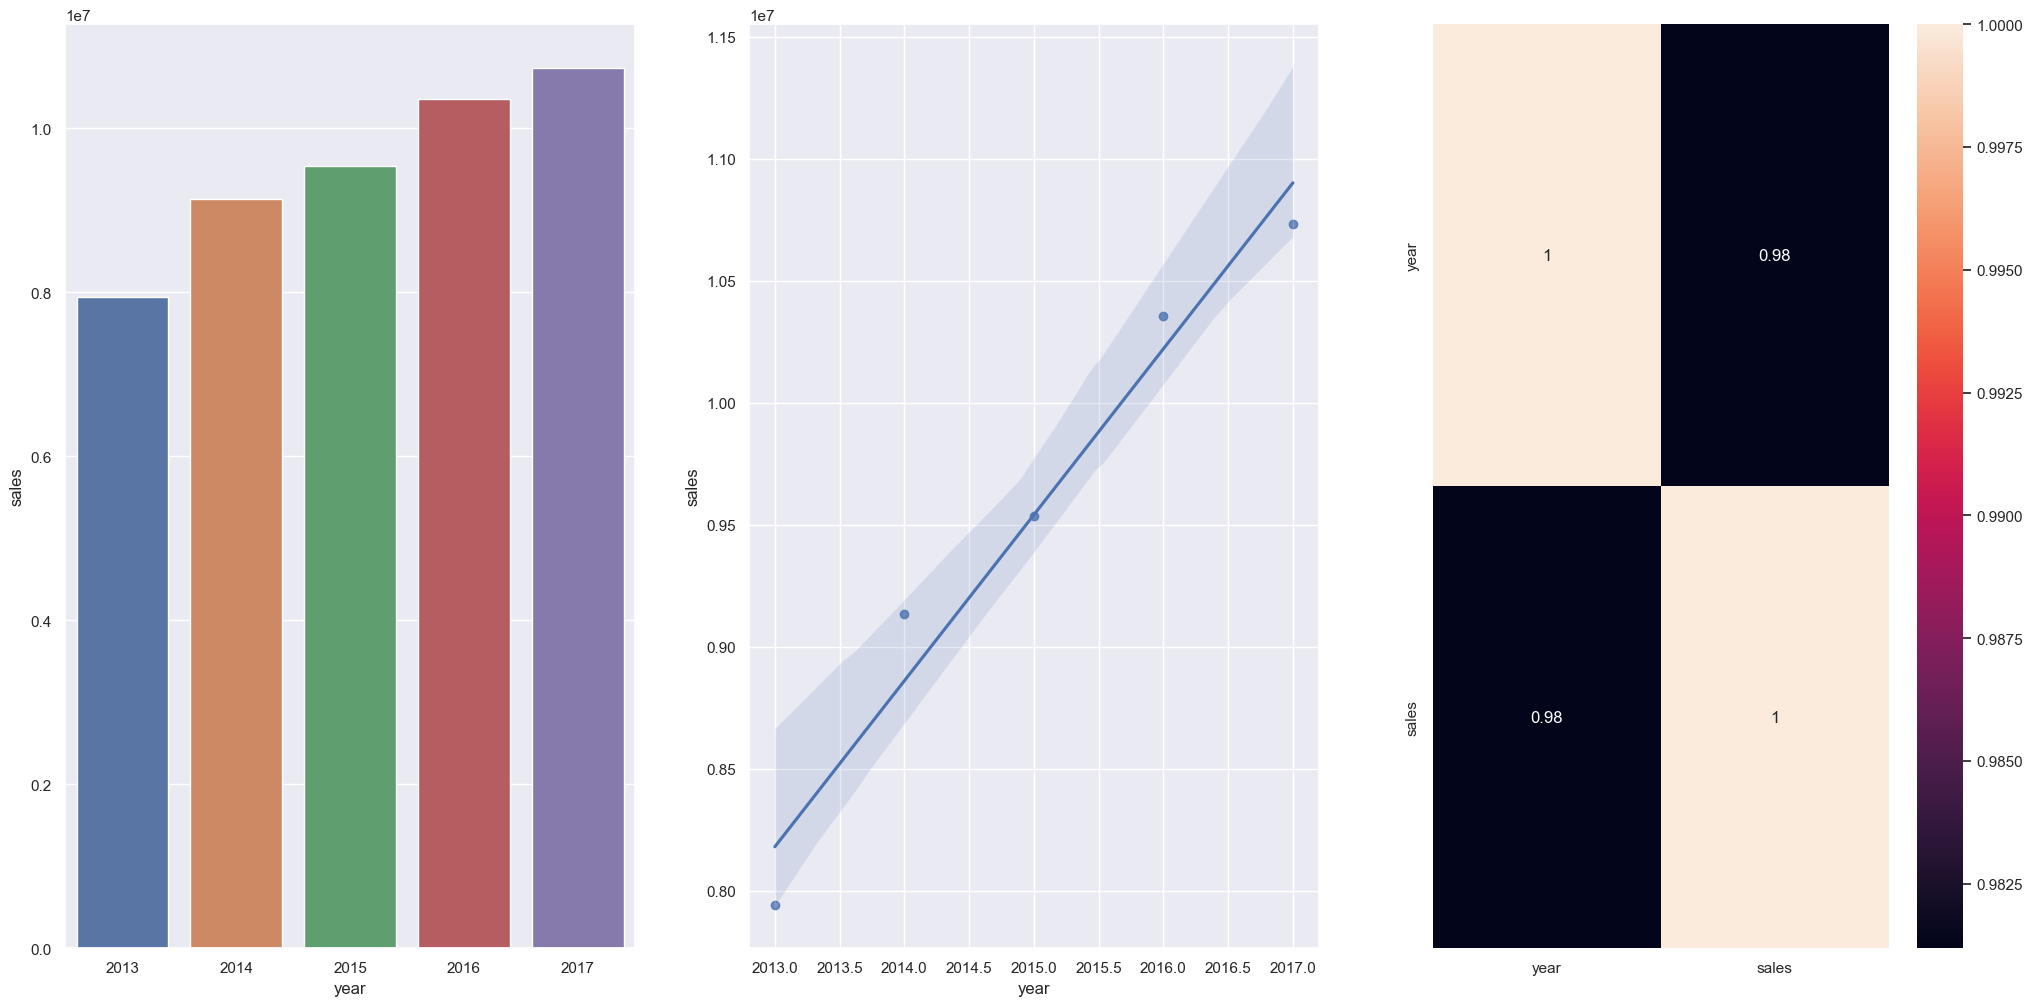

In [31]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H2. Stores should sell more items in the second half of the year.
**TRUE** Stores sell more items in the second half of the year.

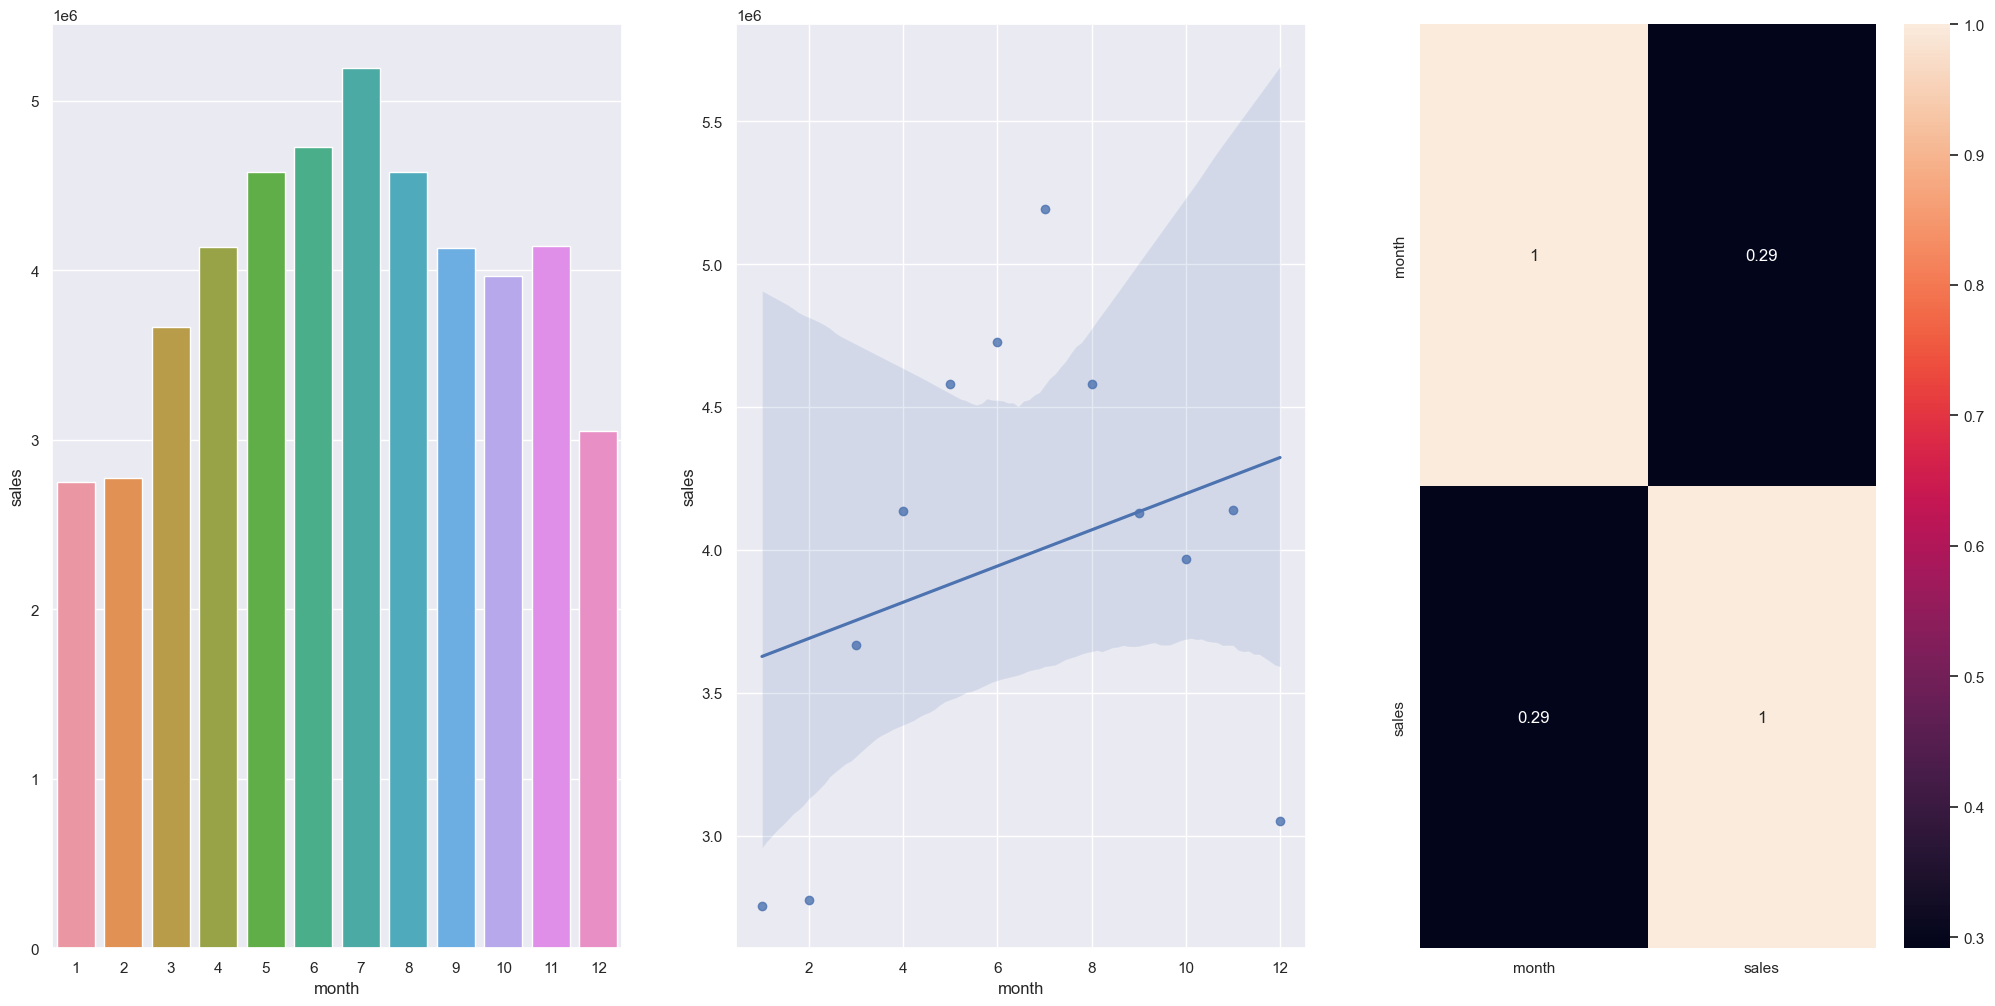

In [32]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H3. Stores should sell more items after the 10th of each month.
**TRUE** Stores sell more items after the 10th of each month.

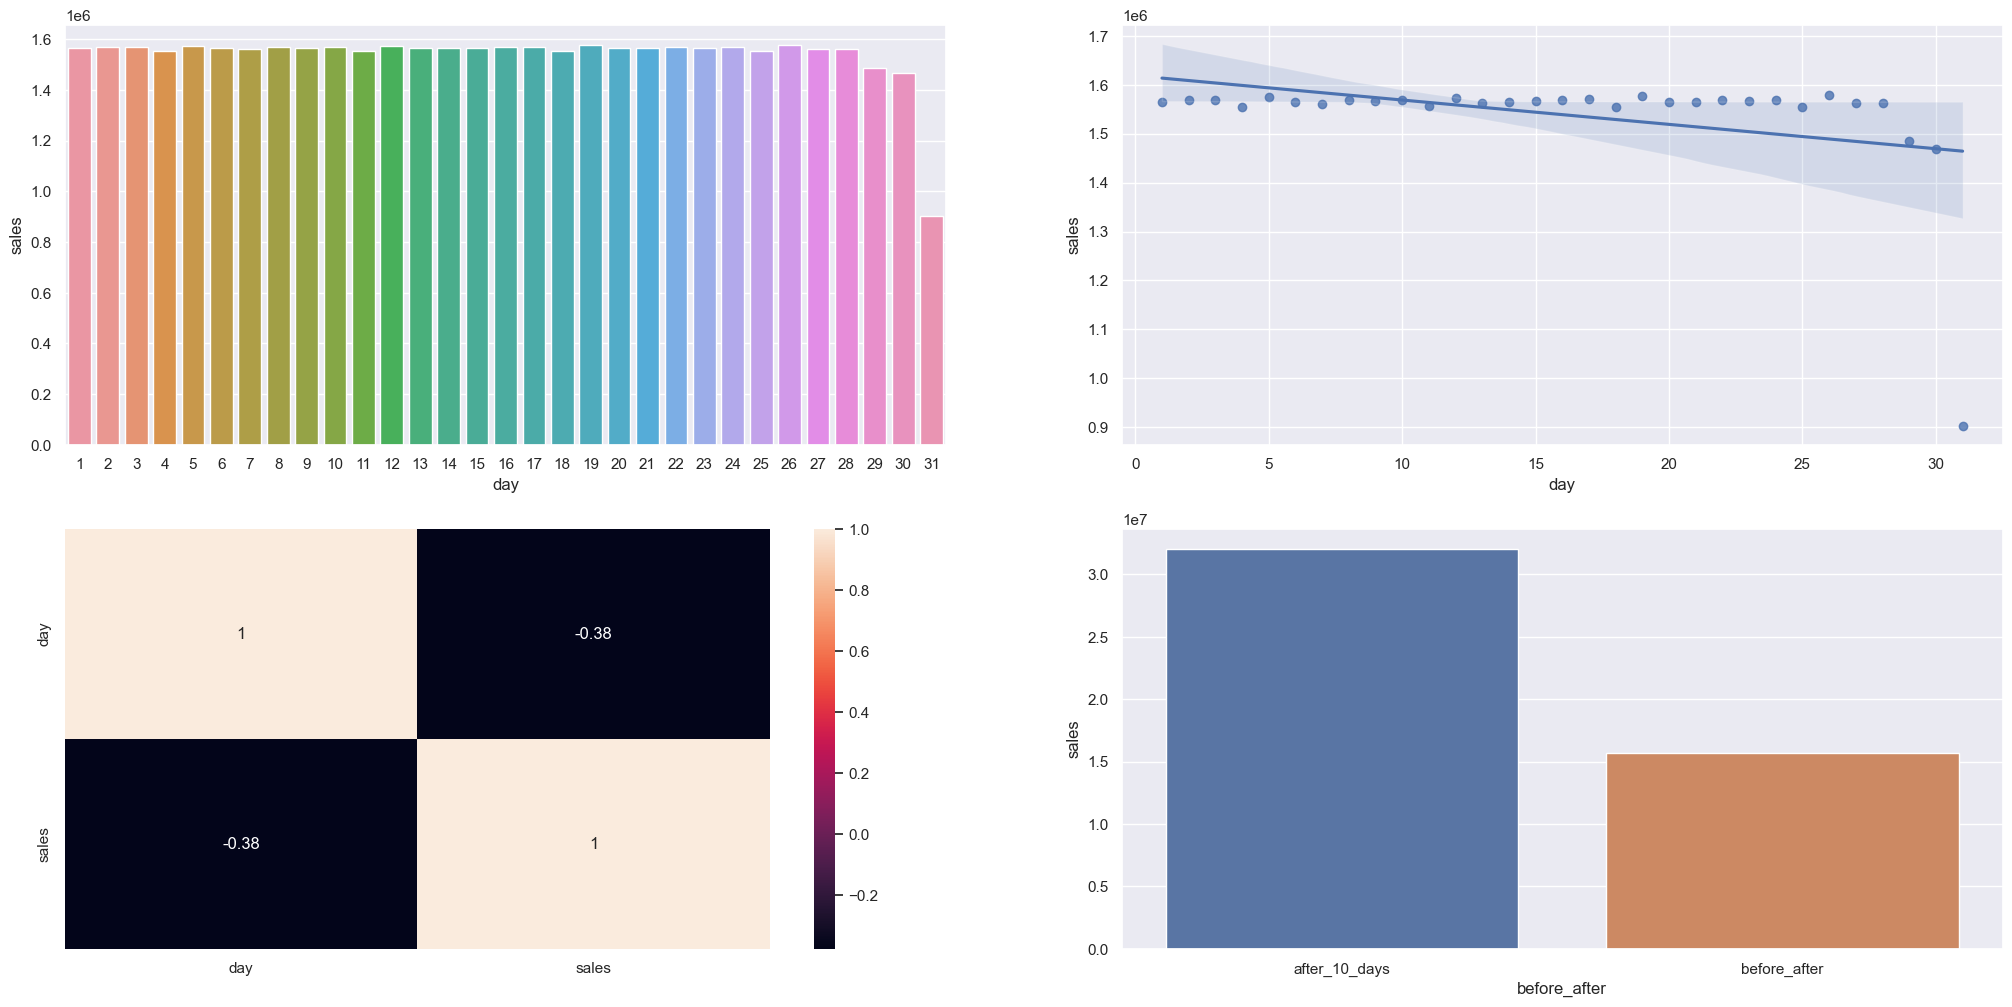

In [33]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_after' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

### H4. Stores should sell less items on weekends.
**TRUE** Stores sell less items on weekends.

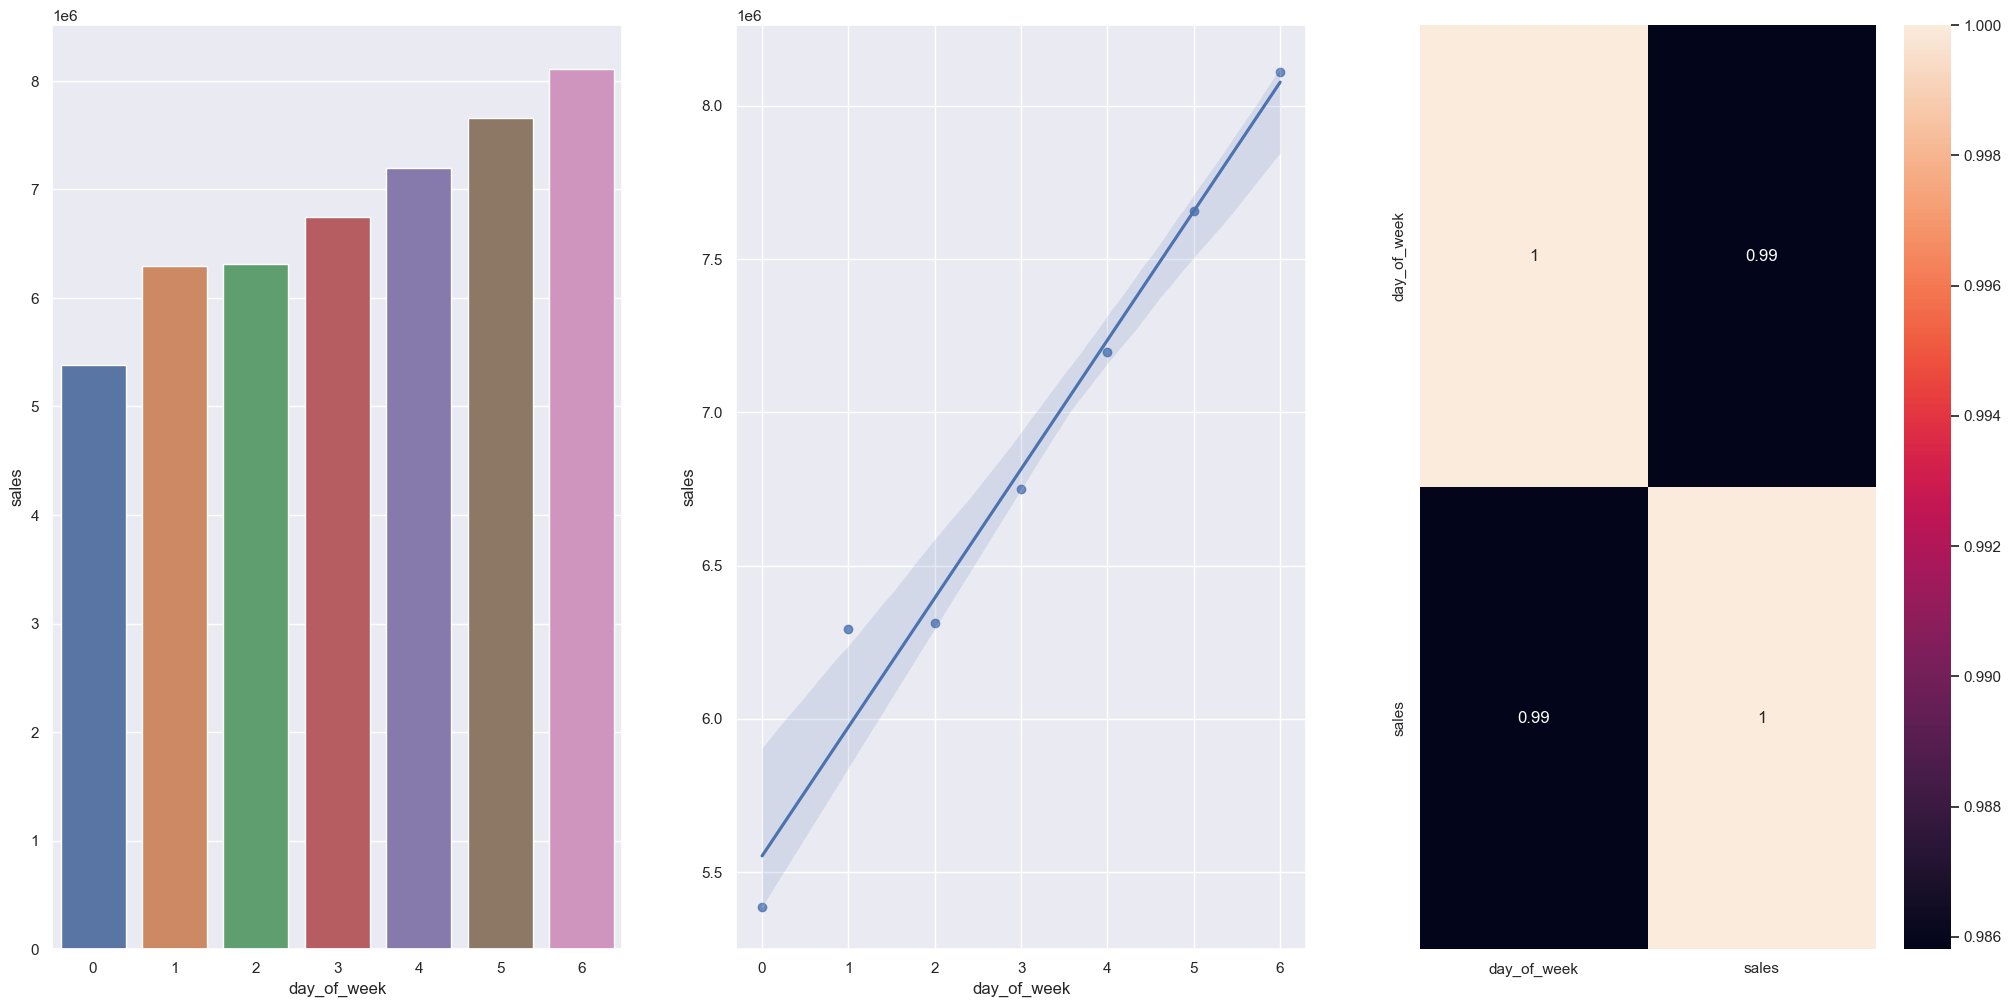

In [34]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
# The day of the week with Monday=0, Sunday=6.
# Return the day of the week. It is assumed the week starts on Monday, which is denoted by 0 and ends on Sunday which is denoted by 6.

### 4.2.1 Hypothesis Summary

In [35]:
tab = [
       ['Hyphoteses', 'Conclusion', 'Relevance'],
       ['H1', 'True', 'High'],
       ['H2', 'True', 'Medium'],
       ['H3', 'True', 'Medium'],
       ['H4', 'True', 'High']
      ]
print(tabulate( tab, headers='firstrow' ))

Hyphoteses    Conclusion    Relevance
------------  ------------  -----------
H1            True          High
H2            True          Medium
H3            True          Medium
H4            True          High


## 4.3. Multivariate Analysis

### 4.3.1 Numerical Attributes

<AxesSubplot: >

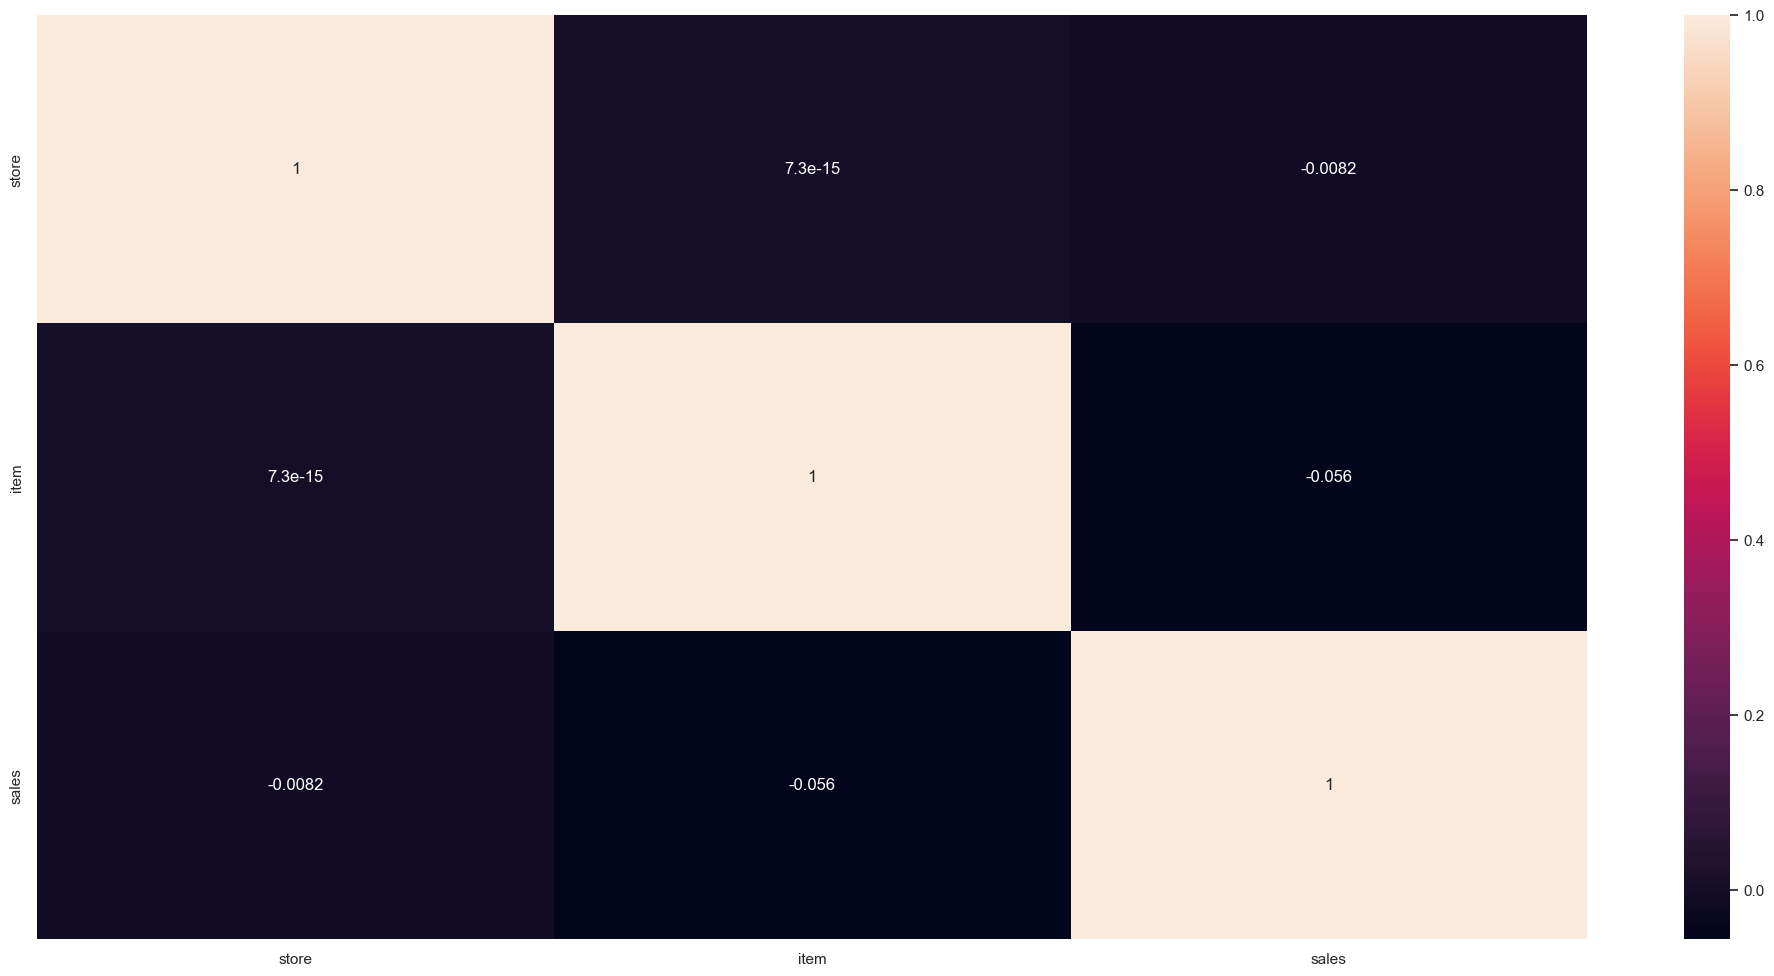

In [36]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True )

### 4.3.2. Categorical Attributes

In [37]:
# There isn't Categorical Variable.

# 5.0 STEP 05 - DATA PREPARATION

In [38]:
df5 = df4.copy()

## 5.1 Normalization

In [39]:
# Go to 4.1.2. Numerical variable to see if there is any Gaussian distribution

# We don't have any data distribution like a Gaussian.

## 5.2 Rescaling

In [40]:
a = df5.select_dtypes( include=['int64', 'float64'] )

In [41]:
a.sample()

,store,item,sales,year,month,day,day_of_week,week_of_year
390215,4,22,111,2016,7,1,4,26


<AxesSubplot: >

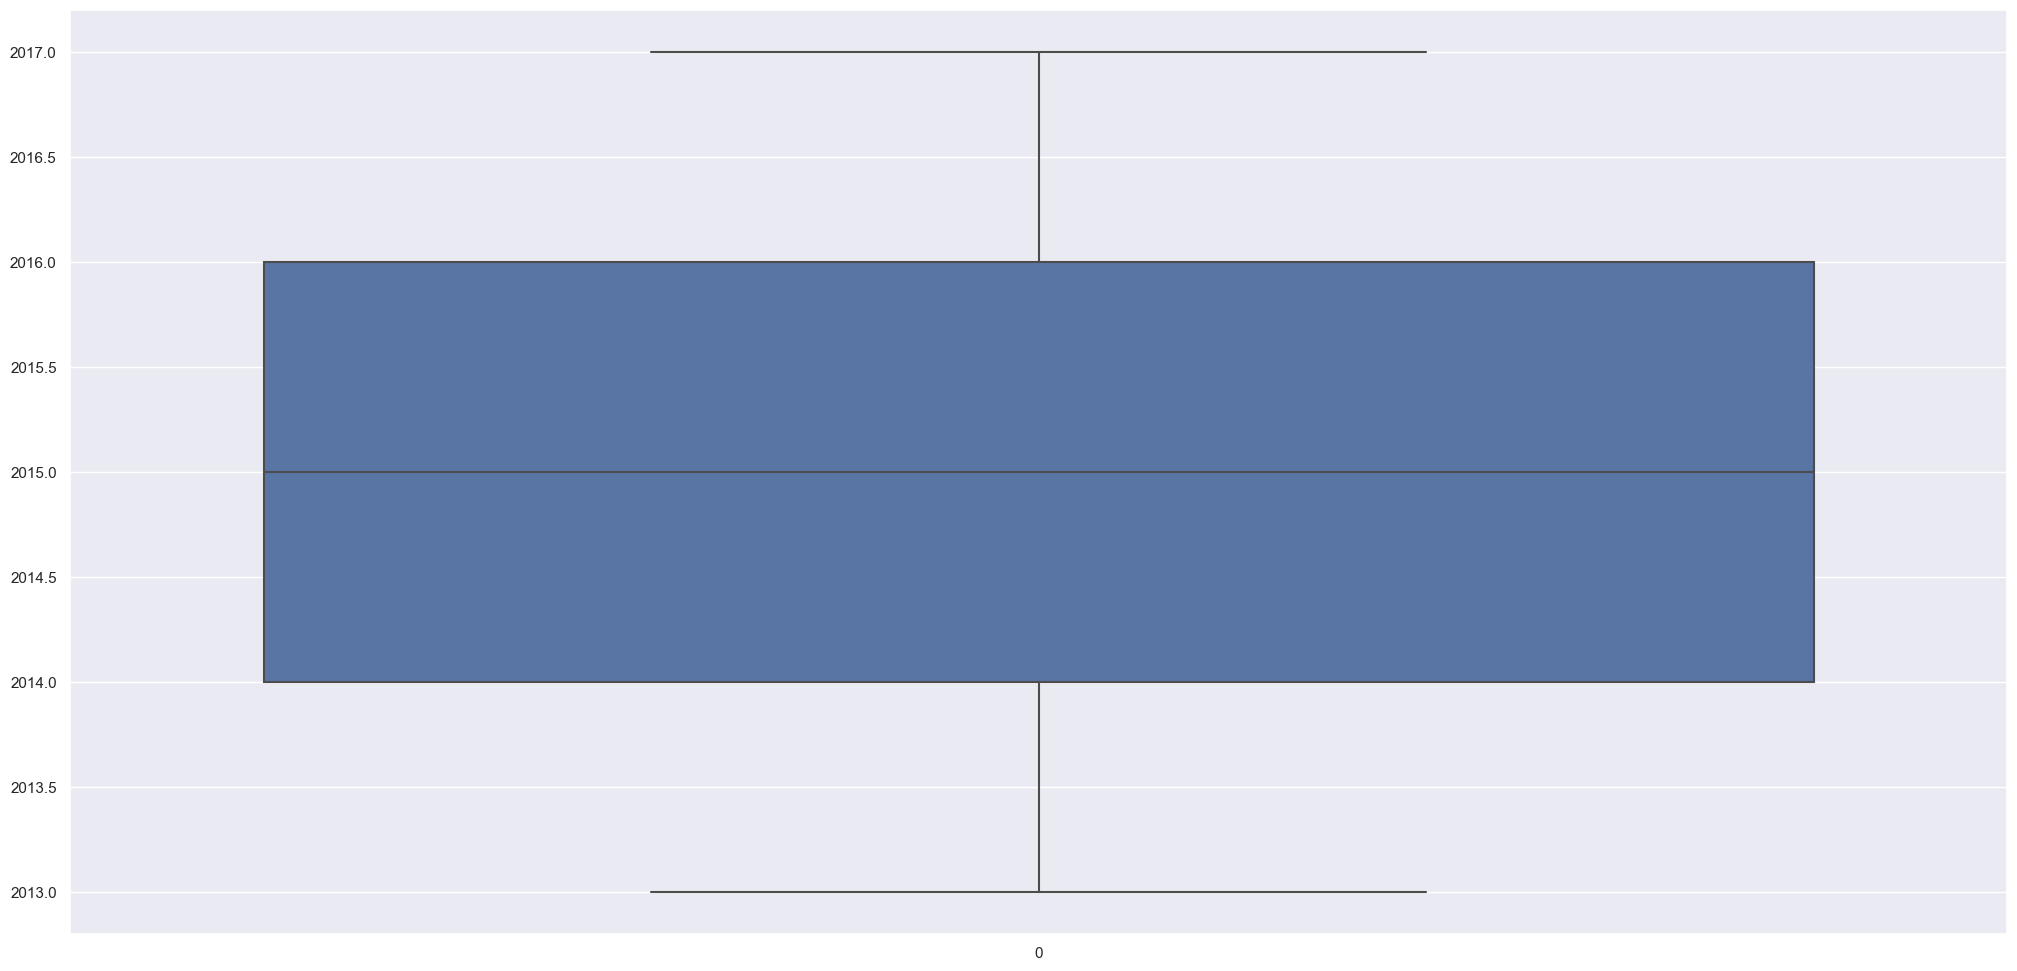

In [42]:
sns.boxplot( df5['year'] )

In [43]:
# Bộ scaler MinMaxScaler sẽ đưa các biến về miền giá trị [0, 1]
mms = MinMaxScaler() 

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
df5.head()

,date,store,item,sales,year,month,day,day_of_week,week_of_year,year_week
0,2013-01-01,1,1,13,0.0,1,1,1,1,2013-00
1,2013-01-02,1,1,11,0.0,1,2,2,1,2013-00
2,2013-01-03,1,1,14,0.0,1,3,3,1,2013-00
3,2013-01-04,1,1,13,0.0,1,4,4,1,2013-00
4,2013-01-05,1,1,10,0.0,1,5,5,1,2013-00


## 5.3 Transformation

### 5.3.1 Encoding

In [44]:
# We don't have categorical values to apply encoding.

### 5.3.2 Response Variable Transformation

In [45]:
df5['sales'] = np.log1p( df5['sales'] )

<AxesSubplot: xlabel='sales', ylabel='Density'>

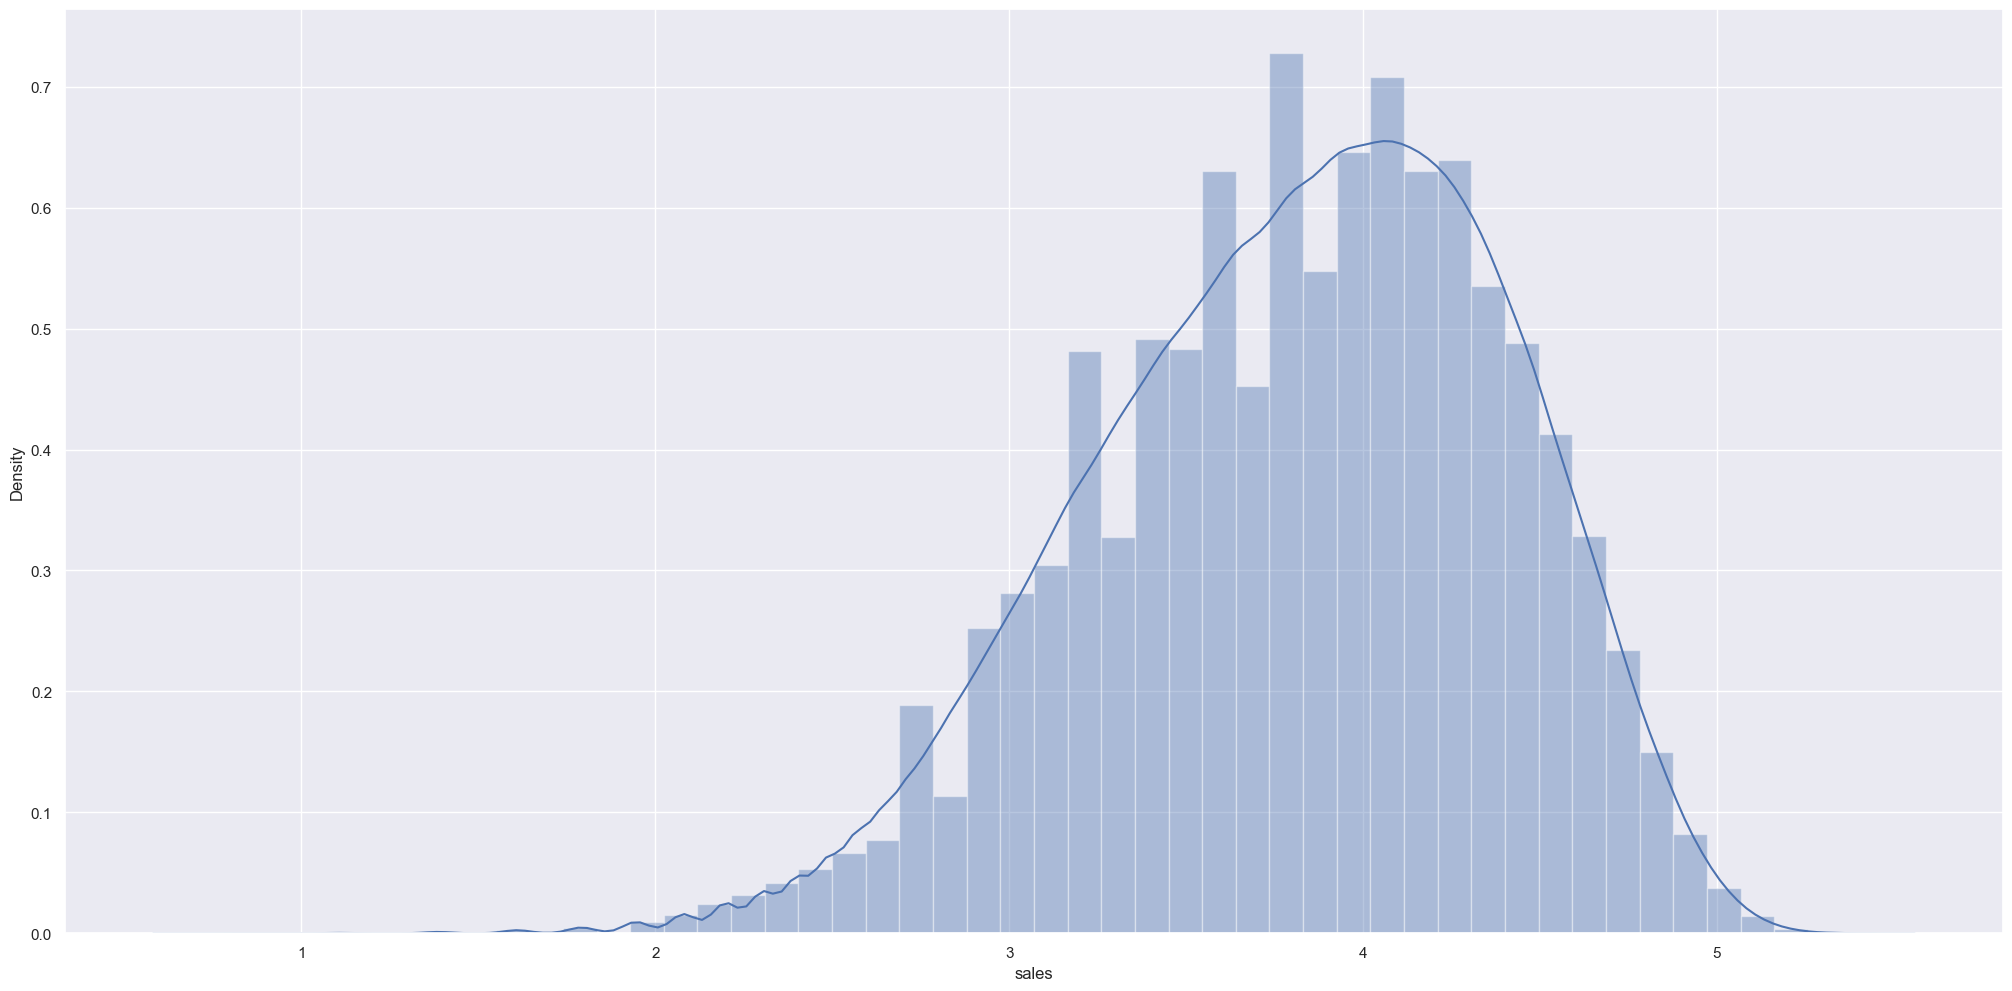

In [46]:
sns.distplot( df5['sales'] )

### 5.3.3. Nature Transformation

In [47]:
# My goal here is to take the numerical data and transform its natures to cyclical.
# The cyclical variable in this dataset are "day_of_week", "month", "day" and "week of year".

# I am not going to go into mathematical details about the method used to turn numeric or categorical variables into cyclical ones, but I am going to give you an idea of what will be done.
# Cyclic behavior looks like a circle. The code will place the values within each variable in this circle and for this the concepts of sine and cosine will be used. 
# Note that at the end of the formula I divide by the amount of cyclic values present in each variable.

In [48]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

In [49]:
df5.sample(5)

,date,store,item,sales,year,month,day,day_of_week,week_of_year,year_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
842448,2014-10-25,2,47,3.761200,0.25,10,25,5,43,2014-42,-0.974928,-0.222521,-0.866025,5.000000e-01,-0.866025,0.500000,-0.885456,0.464723
464805,2015-09-29,5,26,3.891820,0.50,9,29,1,40,2015-39,0.781831,0.623490,-1.000000,-1.836970e-16,-0.207912,0.978148,-0.992709,0.120537
574317,2015-08-12,5,32,3.784190,0.50,8,12,2,33,2015-32,0.974928,-0.222521,-0.866025,-5.000000e-01,0.587785,-0.809017,-0.748511,-0.663123
366212,2015-10-10,1,21,3.850148,0.50,10,10,5,41,2015-40,-0.974928,-0.222521,-0.866025,5.000000e-01,0.866025,-0.500000,-0.970942,0.239316
595052,2017-05-22,6,33,4.007333,1.00,5,22,0,21,2017-21,0.000000,1.000000,0.500000,-8.660254e-01,-0.994522,-0.104528,0.568065,-0.822984


### 5.4 Data Prepare for Deep Learning

In [13]:
train_dl = pd.read_csv('./data/train.csv', parse_dates=['date'])
test_dl = pd.read_csv('./data/test.csv', parse_dates=['date'])

train_gp = df1.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales']
train_gp.head()

,item,store,date,sales
0,1,1,2013-01-01,13.0
1,1,1,2013-01-02,11.0
2,1,1,2013-01-03,14.0
3,1,1,2013-01-04,13.0
4,1,1,2013-01-05,10.0


In [14]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    # Transform the data into a time series problem
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

lag_size = (test_dl['date'].max().date() - train_dl['date'].max().date()).days

# We will use the current timestep and the last 29 to forecast 90 days ahead
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),store(t-26),sales(t-26),item(t-25),store(t-25),sales(t-25),item(t-24),store(t-24),sales(t-24),item(t-23),store(t-23),sales(t-23),item(t-22),store(t-22),sales(t-22),item(t-21),store(t-21),sales(t-21),item(t-20),store(t-20),sales(t-20),item(t-19),store(t-19),sales(t-19),item(t-18),store(t-18),sales(t-18),item(t-17),store(t-17),sales(t-17),item(t-16),store(t-16),sales(t-16),item(t-15),store(t-15),sales(t-15),item(t-14),store(t-14),sales(t-14),item(t-13),store(t-13),sales(t-13),item(t-12),store(t-12),sales(t-12),item(t-11),store(t-11),sales(t-11),item(t-10),store(t-10),sales(t-10),item(t-9),store(t-9),sales(t-9),item(t-8),store(t-8),sales(t-8),item(t-7),store(t-7),sales(t-7),item(t-6),store(t-6),sales(t-6),item(t-5),store(t-5),sales(t-5),item(t-4),store(t-4),sales(t-4),item(t-3),store(t-3),sales(t-3),item(t-2),store(t-2),sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+1827),store(t+1827),sales(t+1827)
29,1.0,1.0,13.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,12.0,1.0,1.0,10.0,1.0,1.0,9.0,1.0,1.0,12.0,1.0,1.0,9.0,1.0,1.0,9.0,1.0,1.0,7.0,1.0,1.0,10.0,1.0,1.0,12.0,1.0,1.0,5.0,1.0,1.0,7.0,1.0,1.0,16.0,1.0,1.0,7.0,1.0,1.0,18.0,1.0,1.0,15.0,1.0,1.0,8.0,1.0,1.0,7.0,1.0,1.0,9.0,1.0,1.0,8.0,1.0,1.0,14.0,1.0,1.0,12.0,1.0,1.0,12.0,1.0,1.0,11.0,1.0,1.0,6.0,1,1,9.0,1.0,2.0,16.0
30,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,12.0,1.0,1.0,10.0,1.0,1.0,9.0,1.0,1.0,12.0,1.0,1.0,9.0,1.0,1.0,9.0,1.0,1.0,7.0,1.0,1.0,10.0,1.0,1.0,12.0,1.0,1.0,5.0,1.0,1.0,7.0,1.0,1.0,16.0,1.0,1.0,7.0,1.0,1.0,18.0,1.0,1.0,15.0,1.0,1.0,8.0,1.0,1.0,7.0,1.0,1.0,9.0,1.0,1.0,8.0,1.0,1.0,14.0,1.0,1.0,12.0,1.0,1.0,12.0,1.0,1.0,11.0,1.0,1.0,6.0,1.0,1.0,9.0,1,1,13.0,1.0,2.0,16.0
31,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,12.0,1.0,1.0,10.0,1.0,1.0,9.0,1.0,1.0,12.0,1.0,1.0,9.0,1.0,1.0,9.0,1.0,1.0,7.0,1.0,1.0,10.0,1.0,1.0,12.0,1.0,1.0,5.0,1.0,1.0,7.0,1.0,1.0,16.0,1.0,1.0,7.0,1.0,1.0,18.0,1.0,1.0,15.0,1.0,1.0,8.0,1.0,1.0,7.0,1.0,1.0,9.0,1.0,1.0,8.0,1.0,1.0,14.0,1.0,1.0,12.0,1.0,1.0,12.0,1.0,1.0,11.0,1.0,1.0,6.0,1.0,1.0,9.0,1.0,1.0,13.0,1,1,11.0,1.0,2.0,23.0
32,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,12.0,1.0,1.0,10.0,1.0,1.0,9.0,1.0,1.0,12.0,1.0,1.0,9.0,1.0,1.0,9.0,1.0,1.0,7.0,1.0,1.0,10.0,1.0,1.0,12.0,1.0,1.0,5.0,1.0,1.0,7.0,1.0,1.0,16.0,1.0,1.0,7.0,1.0,1.0,18.0,1.0,1.0,15.0,1.0,1.0,8.0,1.0,1.0,7.0,1.0,1.0,9.0,1.0,1.0,8.0,1.0,1.0,14.0,1.0,1.0,12.0,1.0,1.0,12.0,1.0,1.0,11.0,1.0,1.0,6.0,1.0,1.0,9.0,1.0,1.0,13.0,1.0,1.0,11.0,1,1,21.0,1.0,2.0,14.0
33,1.0,1.0,10.0,1.0,1.0,12.0,1.0,1.0,10.0,1.0,1.0,9.0,1.0,1.0,12.0,1.0,1.0,9.0,1.0,1.0,9.0,1.0,1.0,7.0,1.0,1.0,10.0,1.0,1.0,12.0,1.0,1.0,5.0,1.0,1.0,7.0,1.0,1.0,16.0,1.0,1.0,7.0,1.0,1.0,18.0,1.0,1.0,15.0,1.0,1.0,8.0,1.0,1.0,7.0,1.0,1.0,9.0,1.0,1.0,8.0,1.0,1.0,14.0,1.0,1.0,12.0,1.0,1.0,12.0,1.0,1.0,11.0,1.0,1.0,6.0,1.0,1.0,9.0,1.0,1.0,13.0,1.0,1.0,11.0,1.0,1.0,21.0,1,1,15.0,1.0,2.0,18.0


In [15]:
from sklearn.model_selection import train_test_split

last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train_dl, X_valid_dl, Y_train_dl, Y_valid_dl = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train_dl.shape)
print('Validation set shape', X_valid_dl.shape)
X_train_dl.head()

Train set shape (538021, 30)
Validation set shape (358681, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),sales(t-19),sales(t-18),sales(t-17),sales(t-16),sales(t-15),sales(t-14),sales(t-13),sales(t-12),sales(t-11),sales(t-10),sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
639289,65.0,53.0,73.0,56.0,66.0,59.0,81.0,58.0,62.0,41.0,73.0,69.0,69.0,84.0,70.0,55.0,59.0,65.0,66.0,93.0,77.0,66.0,71.0,71.0,79.0,84.0,81.0,83.0,67.0,73.0
566875,24.0,36.0,40.0,46.0,38.0,30.0,42.0,26.0,34.0,46.0,45.0,25.0,28.0,37.0,39.0,36.0,40.0,56.0,36.0,43.0,39.0,44.0,34.0,35.0,41.0,28.0,33.0,36.0,29.0,42.0
724173,29.0,12.0,16.0,16.0,19.0,23.0,21.0,32.0,19.0,26.0,23.0,15.0,23.0,31.0,20.0,17.0,13.0,13.0,16.0,14.0,20.0,20.0,13.0,17.0,7.0,15.0,12.0,11.0,13.0,11.0
102132,64.0,51.0,62.0,56.0,64.0,56.0,54.0,49.0,47.0,66.0,59.0,70.0,70.0,56.0,55.0,57.0,58.0,59.0,69.0,65.0,49.0,42.0,47.0,59.0,65.0,63.0,82.0,41.0,50.0,55.0
195968,113.0,138.0,84.0,87.0,90.0,110.0,119.0,117.0,114.0,70.0,101.0,100.0,88.0,110.0,123.0,115.0,80.0,99.0,87.0,92.0,91.0,122.0,99.0,81.0,77.0,108.0,97.0,93.0,101.0,116.0


# 6.0 STEP 06 - FEATURE SELECTION

In [53]:
df6 = df5.copy()

In [54]:
df6.shape

(912999, 18)

## 6.1. Split dataframe into training and test dataset

In [55]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )

In [56]:
df6.sample()

,date,store,item,sales,year,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
629423,2016-07-03,5,35,4.59512,0.75,-0.781831,0.62349,-0.5,-0.866025,0.587785,0.809017,1.224647e-16,-1.0


In [57]:
# As we will predict the next 3 months, I will use the calculation (30*3) to subtract from the max date inside dataset.
df6[['store', 'item', 'date']].groupby( ['store', 'item'] ).max().reset_index()['date'][0] - datetime.timedelta( days=30*3 )

Timestamp('2017-10-02 00:00:00')

In [58]:
# training dataset
X_train = df6[df6['date'] < '2017-10-02']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2017-10-02']
y_test = X_test['sales']

X_train_ = df6[df6['date'] < '2017-01-02']
y_train_ = X_train_['sales']

X_test_12 = df6[df6['date'] >= '2017-01-02']
y_test_12 = X_test_12['sales']

print( 'Training Min Date: {}'.format( X_train_['date']. min() ) )
print( 'Training Max Date: {}'.format( X_train_['date']. max() ) )

print( '\nTest Min Date: {}'.format( X_test_12['date']. min() ) )
print( 'Test Max Date: {}'.format( X_test_12['date']. max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2017-01-01 00:00:00

Test Min Date: 2017-01-02 00:00:00
Test Max Date: 2017-12-31 00:00:00


## 6.2. Boruta as Feature Selector

In [58]:
# training and test dataset for Boruta
X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
y_train_n = y_train.values.ravel()

# define RandomForestRegression
rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	3


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	3


### 6.2.1. Best Feature from Boruta

In [60]:
cols_selected = boruta.support_.tolist()

# best feature
X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [61]:
cols_selected_boruta

['store',
 'item',
 'year',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'week_of_year_sin',
 'week_of_year_cos']

In [62]:
cols_not_selected_boruta

['day_cos', 'day_sin', 'month_cos']

## 6.3. Manual Feature Selection

In [59]:
cols_selected_boruta = [
     'store',
     'item',
     'year',
     'day_of_week_sin',
     'day_of_week_cos',
     'month_sin',
     'month_cos',
     'week_of_year_sin',
     'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [60]:
cols_selected_boruta

['store',
 'item',
 'year',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'week_of_year_sin',
 'week_of_year_cos']

In [61]:
cols_selected_boruta_full

['store',
 'item',
 'year',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

# 7.0 STEP 07 - MACHINE LEARNING MODELLING

In [62]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparartion
X_training = X_train[ cols_selected_boruta_full ]
x_test_full = X_test[ cols_selected_boruta_full ]

x_train_ = X_train_[ cols_selected_boruta ]
x_test_12 = X_test_12[ cols_selected_boruta ]

# Time Series Data Preparartion
X_training_ = X_train_[ cols_selected_boruta_full ]
x_test_full_ = X_test_12[ cols_selected_boruta_full ]

## 7.1 Average Model

In [63]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'item', 'sales']].groupby( ['store', 'item'] ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on=['store', 'item'] )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,10.026081,1.19464,13.267076


## 7.2 Linear Regression Model

In [64]:
# model
lr = LinearRegression().fit( x_train_, y_train_ )

# prediction
yhat_lr = lr.predict( x_test_12 )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test_12 ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,23.726201,0.544667,29.755104


In [65]:
x_test_plot = X_test_12
x_test_plot['prediction'] = np.expm1( yhat_lr )
x_test_plot.date = x_test_plot.date.apply(lambda x: str(x)[:7])
x_test_plot = x_test_plot.groupby('date')['prediction'].sum().reset_index()
x_test_plot.date = pd.to_datetime(x_test_plot.date)
x_test_plot.head()

,date,prediction
0,2017-01-01,618945.619151
1,2017-02-01,603812.567868
2,2017-03-01,735786.478598
3,2017-04-01,813446.134486
4,2017-05-01,937717.405278


In [71]:
def load_original_df():
    #load in original dataframe without scaling applied
    original_df = pd.read_csv('./data/train.csv')
    original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('date')['sales'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.date)
    return original_df


[Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Sales'),
 Text(0.5, 1.0, 'LinearRegression Forecasting Prediction')]

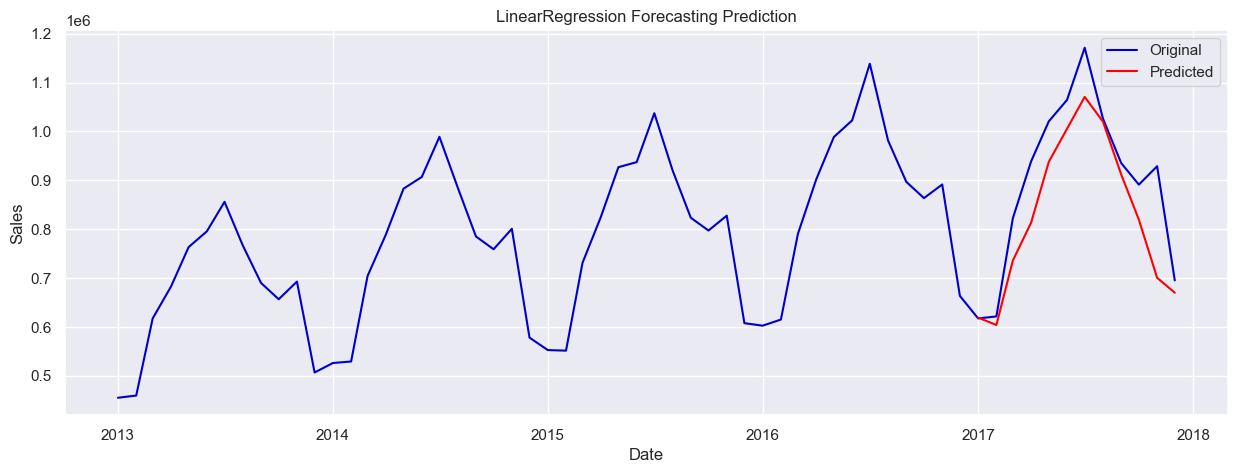

In [68]:
original_df = load_original_df()
# original_df.head()
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x='date',y= 'sales', data=original_df, ax=ax, 
                label='Original', color='mediumblue')
sns.lineplot(x = 'date', y='prediction', data=x_test_plot, ax=ax, 
                 label='Predicted', color='Red')
    
ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = "LinearRegression Forecasting Prediction")

In [69]:
def plot_results(results, original_df, model_name):

       original_df = load_original_df()
       # original_df.head()
       fig, ax = plt.subplots(figsize=(15,5))
       sns.lineplot(x='date',y= 'sales', data=original_df, ax=ax, 
                     label='Original', color='mediumblue')
       sns.lineplot(x = 'date', y='prediction', data=results, ax=ax, 
                     label='Predicted', color='Red')
       
       ax.set(xlabel = "Date",
              ylabel = "Sales",
              title = f"{model_name} Forecasting Prediction")
       
       ax.legend()
       
       sns.despine()
    
    # plt.savefig(f'../model_output/{model_name}_forecast.png')

### 7.2.1 Linear Regression Model - Cross Validation

In [203]:
lr_result_cv = cross_validation( X_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,24.04 +/- 3.19,0.53 +/- 0.02,30.0 +/- 3.78


## 7.3 Linear Regression Regularized Model

In [80]:
# model
lrr = Lasso( alpha=0.00001 ).fit( x_train_, y_train_ )

# prediction
yhat_lrr = lrr.predict( x_test_12 )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test_12 ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,23.726321,0.544624,29.755941


### 7.3.1 Linear Regression - Lasso - Cross Validation

In [205]:
lrr_result_cv = cross_validation( X_training_, 5, 'Linear Regression - Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,22.45 +/- 3.11,0.52 +/- 0.02,28.35 +/- 3.67


In [76]:
def x_test_plott(y_prediction):
    x_test_plot = X_test_12
    x_test_plot['prediction'] = np.expm1( y_prediction )
    x_test_plot.date = x_test_plot.date.apply(lambda x: str(x)[:7])
    x_test_plot = x_test_plot.groupby('date')['prediction'].sum().reset_index()
    x_test_plot.date = pd.to_datetime(x_test_plot.date)
    return x_test_plot

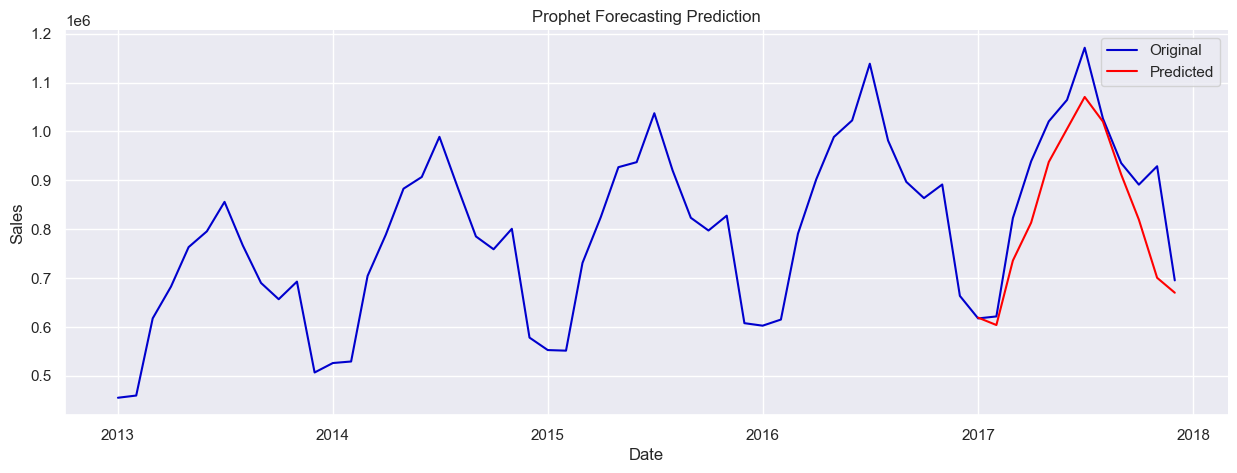

In [82]:

a = x_test_plott(yhat_lrr)
plot_results(a,original_df=original_df, model_name= "Prophet")

## 7.4 Random Forest Regressor

In [214]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train_, y_train_ )

# prediction
yhat_rf = rf.predict( x_test_12 )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test_12 ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,7.348858,0.144437,9.608308


### 7.4.1. Random Forest Regressor - Cross Validation

In [73]:
rf_result_cv = cross_validation( X_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,7.26 +/- 0.42,0.14 +/- 0.01,9.47 +/- 0.53


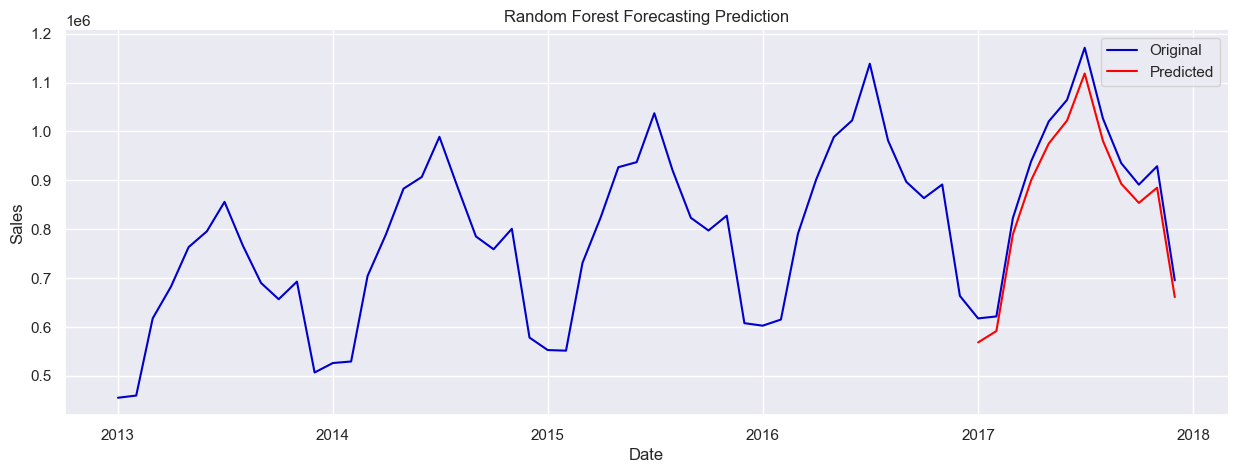

In [215]:
a = x_test_plott(yhat_rf)
plot_results(a, original_df=original_df, model_name= "Random Forest")

## 7.5. XGBoost Regressor

In [216]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                             n_estimators=1000, 
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9 ).fit( x_train_, y_train_ )

# prediction
yhat_xgb = model_xgb.predict( x_test_12 )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test_12 ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6.547059,0.125041,8.661283


### 7.5.1. XGBoost Regressor - Cross Validation

In [76]:
xgb_result_cv = cross_validation( X_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv 


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,6.53 +/- 0.43,0.12 +/- 0.01,8.59 +/- 0.56


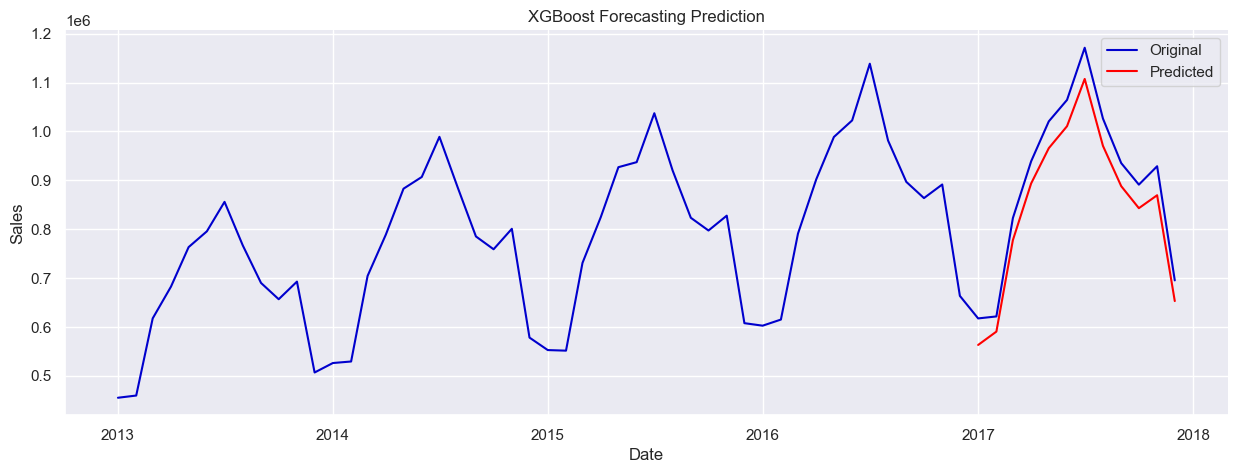

In [217]:
a = x_test_plott(yhat_xgb)
plot_results(a, original_df=original_df, model_name= "XGBoost")

## 7.6 FaceBook Prophet

In [67]:
prophet_df = X_train[ cols_selected_boruta_full ]
prophet_df = prophet_df.rename(columns={'date':'ds', 'sales':'y'})
prophet_df.head()

,store,item,year,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos,ds,y
0,1,1,0.0,0.781831,0.623490,0.5,0.866025,0.120537,0.992709,2013-01-01,2.639057
1,1,1,0.0,0.974928,-0.222521,0.5,0.866025,0.120537,0.992709,2013-01-02,2.484907
2,1,1,0.0,0.433884,-0.900969,0.5,0.866025,0.120537,0.992709,2013-01-03,2.708050
3,1,1,0.0,-0.433884,-0.900969,0.5,0.866025,0.120537,0.992709,2013-01-04,2.639057
4,1,1,0.0,-0.974928,-0.222521,0.5,0.866025,0.120537,0.992709,2013-01-05,2.397895


In [68]:
from prophet import Prophet

playoffs = pd.DataFrame({
        'holiday': 'playoff',
        'ds': pd.to_datetime(['2013-07-12', '2014-07-12', '2014-07-19', '2014-07-02', '2015-07-11', '2016-07-17', '2016-07-24', '2016-07-07','2016-07-24']),
        'lower_window': 0,
        'upper_window': 1
    })

superbowls = pd.DataFrame({
        'holiday': 'superbowl',
        'ds': pd.to_datetime(['2013-01-01', '2013-12-25', '2014-01-01', '2014-12-25','2015-01-01', '2015-12-25','2016-01-01', '2016-12-25', '2017-01-01', '2017-12-25']),
        'lower_window': 0,
        'upper_window': 1
    })
holidays = pd.concat((playoffs, superbowls))
model_prophet = Prophet()
model_prophet.add_seasonality(name='daily', period=60, fourier_order=5)
model_prophet = Prophet(holidays = holidays)
model_prophet.add_country_holidays(country_name='US')
model_prophet.fit(prophet_df)


INFO:prophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [69]:
test_prophet = X_test
test_prophet = test_prophet.rename(columns={'date':'ds', 'sales':'y'})
test_prophet_fcst = model_prophet.predict(test_prophet)
test_prophet_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),Christmas Day (Observed)_lower,Christmas Day (Observed)_upper,Columbus Day,Columbus Day_lower,Columbus Day_upper,Independence Day,Independence Day_lower,Independence Day_upper,Independence Day (Observed),Independence Day (Observed)_lower,Independence Day (Observed)_upper,Labor Day,Labor Day_lower,Labor Day_upper,Martin Luther King Jr. Day,Martin Luther King Jr. Day_lower,Martin Luther King Jr. Day_upper,Memorial Day,Memorial Day_lower,Memorial Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,New Year's Day (Observed),New Year's Day (Observed)_lower,New Year's Day (Observed)_upper,Thanksgiving,Thanksgiving_lower,Thanksgiving_upper,Veterans Day,Veterans Day_lower,Veterans Day_upper,Veterans Day (Observed),Veterans Day (Observed)_lower,Veterans Day (Observed)_upper,Washington's Birthday,Washington's Birthday_lower,Washington's Birthday_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-10-02,3.950026,3.050434,4.396594,3.950026,3.950026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.188598,-0.188598,-0.188598,-0.002411,-0.002411,-0.002411,0.0,0.0,0.0,-0.219111,-0.219111,-0.219111,0.032924,0.032924,0.032924,0.0,0.0,0.0,3.761428
1,2017-10-02,3.950026,3.122577,4.456788,3.950026,3.950026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.188598,-0.188598,-0.188598,-0.002411,-0.002411,-0.002411,0.0,0.0,0.0,-0.219111,-0.219111,-0.219111,0.032924,0.032924,0.032924,0.0,0.0,0.0,3.761428
2,2017-10-02,3.950026,3.095104,4.435923,3.950026,3.950026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.188598,-0.188598,-0.188598,-0.002411,-0.002411,-0.002411,0.0,0.0,0.0,-0.219111,-0.219111,-0.219111,0.032924,0.032924,0.032924,0.0,0.0,0.0,3.761428
3,2017-10-02,3.950026,3.061719,4.421099,3.950026,3.950026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.188598,-0.188598,-0.188598,-0.002411,-0.002411,-0.002411,0.0,0.0,0.0,-0.219111,-0.219111,-0.219111,0.032924,0.032924,0.032924,0.0,0.0,0.0,3.761428
4,2017-10-02,3.950026,3.084187,4.431141,3.950026,3.950026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.188598,-0.188598,-0.188598,-0.002411,-0.002411,-0.002411,0.0,0.0,0.0,-0.219111,-0.219111,-0.219111,0.032924,0.032924,0.032924,0.0,0.0,0.0,3.761428


In [ ]:
def cross_validation_prophet( X_training, kfold, model_name, model, verbose=False ):
    
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation
        validation_start_date = X_training['date'].max() - datetime.timedelta( days=k*30*3 )
        validation_end_date = X_training['date'].max() - datetime.timedelta( days=(k-1)*30*3 )

        # filtering dataset
        training = X_training[X_training['date'] < validation_start_date]
        validation = X_training[(X_training['date'] >= validation_start_date) & (X_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales' ], axis=1 )
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold interation
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( { 'Model Name': model_name,
                            'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                            'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                            'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


In [70]:
prophet_result = ml_error( 'FB Prophet', np.expm1( test_prophet['y'] ), np.expm1( test_prophet_fcst['yhat']) )
prophet_result

,Model Name,MAE,MAPE,RMSE
0,FB Prophet,23.318184,0.765117,29.954338


In [ ]:
prophet_result_cv = cross_validation( X_training, 5, 'XGBoost Regressor', model_prophet, verbose=True )
prophet_result_cv 

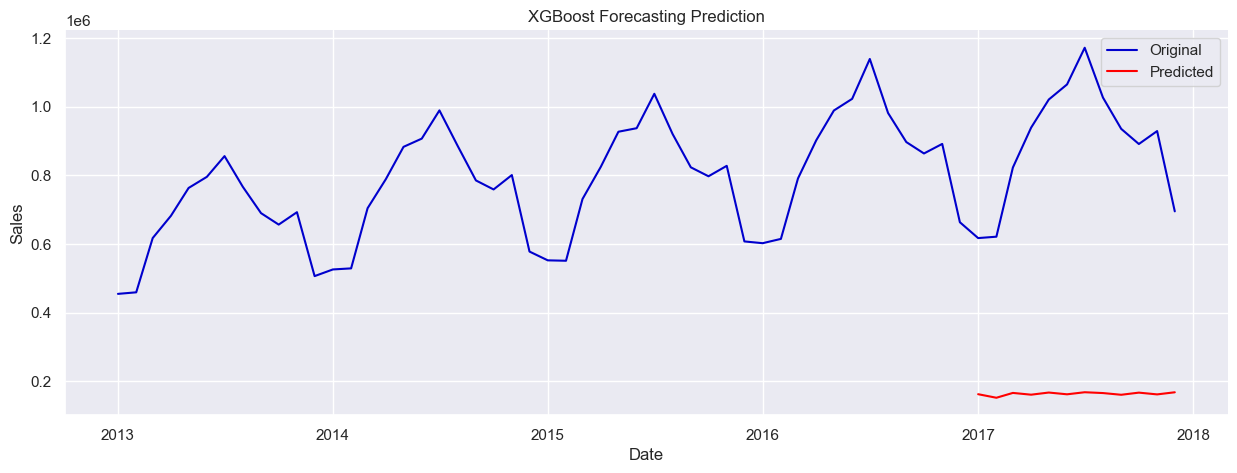

In [79]:
original_df = load_original_df()
a = x_test_plott(test_prophet_fcst['yhat'])
plot_results(a, original_df=original_df, model_name= "XGBoost")

## 7.7 LSTM

In [16]:
X_train_series = X_train_dl.values.reshape((X_train_dl.shape[0], X_train_dl.shape[1], 1))
X_valid_series = X_valid_dl.values.reshape((X_valid_dl.shape[0], X_valid_dl.shape[1], 1))

model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer='adam')
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [17]:
epochs = 40
batch = 256
lr = 0.0003

lstm_history = model_lstm.fit(X_train_series, Y_train_dl, validation_data=(X_valid_series, Y_valid_dl), epochs=epochs, verbose=2)

Epoch 1/40
16814/16814 - 267s - loss: 457.6133 - val_loss: 369.1576 - 267s/epoch - 16ms/step
Epoch 2/40
16814/16814 - 247s - loss: 359.7088 - val_loss: 352.5349 - 247s/epoch - 15ms/step
Epoch 3/40
16814/16814 - 263s - loss: 355.3572 - val_loss: 361.5953 - 263s/epoch - 16ms/step
Epoch 4/40
16814/16814 - 263s - loss: 395.9653 - val_loss: 398.4343 - 263s/epoch - 16ms/step
Epoch 5/40
16814/16814 - 252s - loss: 378.2580 - val_loss: 377.1645 - 252s/epoch - 15ms/step
Epoch 6/40
16814/16814 - 227s - loss: 367.1643 - val_loss: 360.1770 - 227s/epoch - 13ms/step
Epoch 7/40
16814/16814 - 147s - loss: 358.5894 - val_loss: 354.5107 - 147s/epoch - 9ms/step
Epoch 8/40
16814/16814 - 142s - loss: 359.3209 - val_loss: 363.8062 - 142s/epoch - 8ms/step
Epoch 9/40
16814/16814 - 169s - loss: 355.0796 - val_loss: 351.4392 - 169s/epoch - 10ms/step
Epoch 10/40
16814/16814 - 163s - loss: 359.4722 - val_loss: 350.7143 - 163s/epoch - 10ms/step
Epoch 11/40
16814/16814 - 148s - loss: 346.8408 - val_loss: 348.7799 - 

In [18]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_lstm.predict(X_valid_series)

11209/11209 [==============================] - 44s 4ms/step


In [22]:
print('Valid rmse:', np.sqrt(mean_squared_error(Y_valid_dl, lstm_valid_pred)))

Valid rmse: 23.7322077529008


In [20]:
print('Train mae:', mean_absolute_error(Y_train_dl, lstm_train_pred))

Train mae: 24.2901828905834


## 7.6. Compare Model's Performance

### 7.6.1 Single Performance

In [75]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

NameError: name 'lr_result' is not defined

### 7.6.2. Real Performance - Cross Validation

In [83]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,24.04 +/- 3.19,0.53 +/- 0.02,30.0 +/- 3.78
0,Linear Regression - Lasso,24.04 +/- 3.19,0.53 +/- 0.02,30.01 +/- 3.78
0,Random Forest Regressor,7.26 +/- 0.42,0.14 +/- 0.01,9.47 +/- 0.53
0,XGBoost Regressor,6.53 +/- 0.43,0.12 +/- 0.01,8.59 +/- 0.56


# 8.0 STEP 08 - HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [76]:
param = { 
        'n_estimators': [1500, 1700, 2500, 3000, 3500],
        'eta': [0.01, 0.03],
        'max_depth': [3, 5, 9],
        'subsample': [0.1, 0.5, 0.7],
        'colsample_bytree': [0.3, 0.7, 0.9],
        'min_child_weight': [3, 8, 15] 
        }

MAX_EVAL = 5

In [77]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL):
    #chose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print( hp )
    
    # model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'], 
                                 eta=hp['eta'],
                                 max_depth=hp['max_depth'],
                                 subsample=hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'] )

    # performance
    result = cross_validation( X_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
    final_result = pd.concat( [final_result, result] )

final_result

{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 8}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 8}
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 8}
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,6.06 +/- 0.41,0.12 +/- 0.01,7.89 +/- 0.52
0,XGBoost Regressor,7.86 +/- 0.73,0.14 +/- 0.01,10.63 +/- 1.0
0,XGBoost Regressor,9.88 +/- 1.09,0.17 +/- 0.01,13.52 +/- 1.42
0,XGBoost Regressor,6.38 +/- 0.5,0.12 +/- 0.01,8.41 +/- 0.64
0,XGBoost Regressor,14.2 +/- 1.89,0.26 +/- 0.01,19.07 +/- 2.43


## 8.3. Grid Search

In [84]:
param = { 
        'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9]
        }

dict_items([('n_estimators', [25, 50, 100, 150]), ('max_features', ['sqrt', 'log2', None]), ('max_depth', [3, 6, 9]), ('max_leaf_nodes', [3, 6, 9])])

In [81]:
final_result_rf = pd.DataFrame()

for i in range( 5):
    #chose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print( hp )
    
    # model
    model_rf = RandomForestRegressor( objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'], 
                                 max_depth=hp['max_depth'],
                                 max_features=hp['max_features'],
                                 max_leaf_nodes=hp['max_leaf_nodes'])
    # performance
    result_rf = cross_validation( X_training, 5, 'XGBoost Regressor', model_rf, verbose=False)
    final_result_rf = pd.concat( [final_result_rf, result_rf] )

final_result_rf

TypeError: random_sample() takes at most 1 positional argument (2 given)

## 8.2. Final Model

In [87]:
param_tuned = { 
        'n_estimators': 3000,
        'eta': 0.03,
        'max_depth': 5,
        'subsample': 0.7,
        'colsample_bytree': 0.3,
        'min_child_weight': 15
        }

In [88]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                            n_estimators=param_tuned['n_estimators'], 
                            eta=param_tuned['eta'],
                            max_depth=param_tuned['max_depth'],
                            subsample=param_tuned['subsample'],
                            colsample_bytree=param_tuned['colsample_bytree'],
                            min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

In [80]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.02457060675908197

# 9.0 STEP 09 - TRANSLATION AND INTERPRETATION OF THE ERROR

In [76]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

NameError: name 'yhat_xgb_tuned' is not defined

## 9.1 Business Performance

In [82]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'} )
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'} )

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAPE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [83]:
# sum of predictions
df93 = df9[['item', 'predictions']].groupby( 'item' ).sum().reset_index()

# MAE e MAPE
df9_aux4 = df9[['item', 'sales', 'predictions']].groupby( 'item' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'} )
df9_aux5 = df9[['item', 'sales', 'predictions']].groupby( 'item' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'} )

# Merge
df9_aux6 = pd.merge( df9_aux4, df9_aux5, how='inner', on='item' )
df94 = pd.merge( df93, df9_aux6, how='inner', on='item' )

# Scenarios
df94['worst_scenario'] = df94['predictions'] - df94['MAE']
df94['best_scenario'] = df94['predictions'] + df94['MAPE']

# order columns
df94 = df94[['item', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [84]:
df9_aux1.head()

,store,MAE
0,1,10.728751
1,2,14.919837
2,3,13.285813
3,4,12.411489
4,5,9.244575


In [85]:
df9_aux4.head()

,item,MAE
0,1,3.733364
1,2,6.471983
2,3,5.148192
3,4,3.910830
4,5,3.529437


In [86]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
6,7,159962.984375,159954.530459,159963.243137,8.453916,0.258762
4,5,173349.046875,173339.802300,173349.297993,9.244575,0.251118
5,6,173328.875000,173319.725236,173329.119679,9.149764,0.244679
0,1,205952.375000,205941.646249,205952.612198,10.728751,0.237198
3,4,237748.062500,237735.651011,237748.296492,12.411489,0.233992


In [87]:
df94.sort_values( 'MAPE', ascending=False ).head()

,item,predictions,worst_scenario,best_scenario,MAE,MAPE
26,27,35811.539062,35794.921987,35812.361759,16.617075,0.822697
22,23,44627.957031,44609.660373,44628.624470,18.296658,0.667438
33,34,36398.871094,36385.807372,36399.419932,13.063722,0.548838
17,18,48007.402344,47972.278611,48007.793930,35.123733,0.391586
15,16,31809.109375,31800.414037,31809.498069,8.695338,0.388694


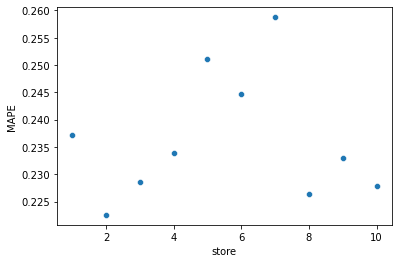

In [88]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

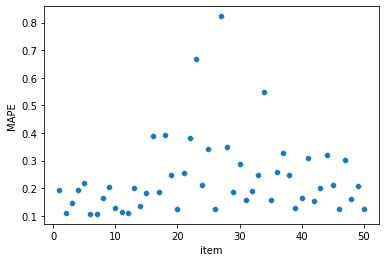

In [89]:
sns.scatterplot( x='item', y='MAPE', data=df94 )

## 9.2. Total Performance

In [90]:
df95 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values p Store'} )
df95['Values p Store'] = df95['Values p Store'].map( '{:,.2f} items'.format )
df95

,Scenario,Values p Store
0,predictions,"2,273,723.75 items"
1,worst_scenario,"2,273,606.21 items"
2,best_scenario,"2,273,726.16 items"


In [91]:
df96 = df94[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values p Item'} )
df96['Values p Item'] = df96['Values p Item'].map( '{:,.2f} items'.format )
df96

,Scenario,Values p Item
0,predictions,"2,273,723.75 items"
1,worst_scenario,"2,273,135.84 items"
2,best_scenario,"2,273,735.62 items"


## 9.3. Machine Learning Performance

In [92]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

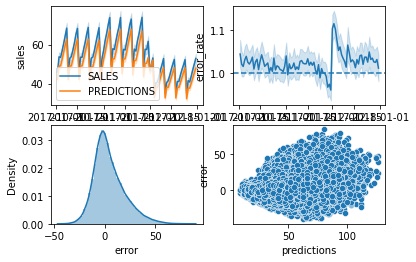

In [93]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--' )

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( x="predictions", y="error", data= df9)

# 10.0 STEP 10 - DEPLOY MODEL TO PRODUCTION

**In this project I won't put the model in production. If you want to see in more details how I do it, check my other project where I did the model deploy. Rossmann Project:** https://github.com/panambY/Rossmann_Store_Sale

In this part, some Python code is built to assemble the entire structure that will trigger the classes and functions to make the model trigger when the store number is entered. In this first moment, the model will be stored in the cloud inside the Heroku platform and accessed through the Jupyter Notebook as a test to verify its correct functioning.

The goal here is to make the prediction model accessible to anyone. To achieve this, an API is created.

The architecture of the model in production:

- **Handler API** -> is the part that receives the requests and plays for the other parts so that the data is processed and then brings everything together, returning the final answer.
- **Data Preparation** -> all the treatments and modifications we made to the data will be kept inside. When the Handler receives the raw data it will throw it here within this list of treatment codes so that they are prepared so that they can be ready to be used within the Machine Learning model.
- **Model Training** -> this is our trained model that has been saved and will be placed inside this folder in our production architecture. The Handler will take the data processed within Data Preparation and play it inside the model so that it provides the prediction.

At the end of the construction of all this architecture and being put into production, the way it will be visualized can be through an App, Dashboard or a website.

In [94]:
import pickle

pickle.dump( model_xgb_tuned, open('C:/Users/Admin/Documents/Đồ án tốt nghiệp/Store_Item_Demand/model/model.pkl', 'wb' ) )

In [95]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

from sklearn.preprocessing import MinMaxScaler

class Rossmann( object ):
        
    def data_cleaning( self, df1 ):
        
        ## 1.1 Rename olumns
        cols_old = ['date', 'store', 'item', 'sales']

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )
    
        return df1

    def feature_engineering( self, df2 ):
        
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # day of week
        df2['day_of_week'] = df2['date'].dt.dayofweek

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # 3.0. STEP 03 - VARIABLE FILTERING
        ## 3.1. Line Filtering
        # df2 = df2[(df2['sales']) != 0]
        
        return df2
    
    def data_preparation( self, df5 ):
        
        ## 5.2. Rescaling
        # year
        mms = MinMaxScaler() 
        df5['year'] = mms.fit_transform( df5[['year']].values ) 
        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        cols_selected = ['store',
                'item',
                'year',
                'day_of_week_sin',
                'day_of_week_cos',
                'month_sin',
                'month_cos',
                'week_of_year_sin',
                'week_of_year_cos']
        return df5[ cols_selected ]
    
    def get_prediction( self, model, original_data, test_data ):
        
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data

In [ ]:
import pandas as pd
df_test = pd.read_csv('./data/test.csv')
df_test[0:10].to_dict().values()

dict_values([{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}, {0: '2023-01-01', 1: '2018-01-02', 2: '2018-01-03', 3: '2018-01-04', 4: '2018-01-05', 5: '2018-01-06', 6: '2018-01-07', 7: '2018-01-08', 8: '2018-01-09', 9: '2018-01-10'}, {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1}, {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1}])